In [1]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from DataSynthesizer.datatypes.utils.DataType import DataType
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

In [2]:
mergedData = pd.read_excel('TabellaFinaleSenzaNaN_con_0.xlsx', sheet_name=None)

In [3]:
mergedData['Sheet1'].head()

Unnamed: 0  HDN_CODE  Sesso  ETA                DATA  ASCVD_Score  \
0           0      2236      0   64 2021-02-26 00:00:00        27.30   
1           1      6426      0   48 2021-04-02 00:00:00         2.56   
2           2      8377      0   56 2020-08-31 00:00:00         7.80   
3           3     11463      0   71 2020-08-31 00:00:00        24.74   
4           4     11463      0   71 2021-03-31 10:54:33         0.00   

   DATA_INT  num_visita  Charlson_Totale  Charlson_Diabete  ...  Stress level  \
0       422           0                0                 0  ...             0   
1       457           0                2                 0  ...             0   
2       243           0                1                 0  ...             0   
3       243           0                3                 0  ...             0   
4       456           1                0                 0  ...             0   

   DASS21 anxiety  Anxiety level  DASS21 depression  Depression level  \
0               0              0                  0                 0   
1               4              1                  7                 2   
2               0              0                  0                 0   
3               0              0                  0                 0   
4               0              0                  0                 0   

   Insomnia severity index  ISI level  SF36 general health  Resilience  \
0                        8          1                   75          64   
1                        6          0                   10          54   
2                        0          0                    0           0   
3                        0          0                    0           0   
4                        0          0                   90          88   

   Outcome  
0        1  
1        0  
2       -1  
3       -1  
4        3  

[5 rows x 81 columns]

In [4]:
# tolgo la prima colonna e seleziono il primo foglio
df = mergedData['Sheet1'].iloc[:, 1:]

In [5]:
df.head()

HDN_CODE  Sesso  ETA                DATA  ASCVD_Score  DATA_INT  \
0      2236      0   64 2021-02-26 00:00:00        27.30       422   
1      6426      0   48 2021-04-02 00:00:00         2.56       457   
2      8377      0   56 2020-08-31 00:00:00         7.80       243   
3     11463      0   71 2020-08-31 00:00:00        24.74       243   
4     11463      0   71 2021-03-31 10:54:33         0.00       456   

   num_visita  Charlson_Totale  Charlson_Diabete  Stifness  ...  Stress level  \
0           0                0                 0       6.7  ...             0   
1           0                2                 0       0.0  ...             0   
2           0                1                 0       0.0  ...             0   
3           0                3                 0       0.0  ...             0   
4           1                0                 0       0.0  ...             0   

   DASS21 anxiety  Anxiety level  DASS21 depression  Depression level  \
0               0              0                  0                 0   
1               4              1                  7                 2   
2               0              0                  0                 0   
3               0              0                  0                 0   
4               0              0                  0                 0   

   Insomnia severity index  ISI level  SF36 general health  Resilience  \
0                        8          1                   75          64   
1                        6          0                   10          54   
2                        0          0                    0           0   
3                        0          0                    0           0   
4                        0          0                   90          88   

   Outcome  
0        1  
1        0  
2       -1  
3       -1  
4        3  

[5 rows x 80 columns]

In [6]:
df.to_csv('TabellaFinaleInput.csv', index=False)
df.to_excel('TabellaFinaleInput.xlsx', index=False)

## Parametri utente

In [7]:
input_data = 'TabellaFinaleInput.csv' 
mode = 'correlated_attribute_mode'
#description_file = 'description_500_completa_correlated_datatypes_0_degree_no_nan.json'
description_file = 'description_definitiva_0.json'
synthetic_data = 'synthetic_data_0.csv'

In [8]:
#for col in df.columns:
#    print(f'\'{col}\': False,')

In [9]:
# An attribute is categorical if its domain size is less than this threshold.
threshold_value = 20

attr_to_datatype = {'HDN_CODE': DataType.INTEGER,
                    'Sesso': DataType.INTEGER,
                    'ETA': DataType.INTEGER,
                    'DATA': DataType.DATETIME,
                    'ASCVD_Score': DataType.FLOAT,
                    'DATA_INT': DataType.INTEGER,
                    'num_visita': DataType.INTEGER,
                    'Charlson_Diabete': DataType.INTEGER,
                    'Stifness': DataType.FLOAT,
                    'CAP': DataType.INTEGER ,
                    'FrailtyPhenotypeBool': DataType.INTEGER ,
                    'EGA_HB': DataType.FLOAT,
                    'EGA_PaO2': DataType.FLOAT ,
                    'EGA_SatO2': DataType.FLOAT ,
                    'Pneumo_ProveFunzResp_FEV_FVCPre': DataType.FLOAT ,
                    'Pneumo_ProveFunzResp_MEP': DataType.FLOAT ,
                    'Pneumo_ProveFunzResp_MIP': DataType.FLOAT ,
                    'Pneumo_ScalaBorg': DataType.FLOAT ,
                    'TestCammino6Min_BorgBase': DataType.FLOAT ,
                    'TestCammino6Min_BorgEnd': DataType.FLOAT ,
                    'TestCammino6Min_Distanza': DataType.INTEGER ,
                    'Alcool': DataType.INTEGER ,
                    'BMI': DataType.FLOAT ,
                    'BMI_Ricovero': DataType.FLOAT ,
                    'BMIPostRicovero': DataType.FLOAT ,
                    'Fumatore': DataType.INTEGER ,
                    'Pack_years': DataType.INTEGER ,
                    'Sintomi_Cadute': DataType.INTEGER ,
                    'Sintomi_DifficoltaDeglutizione': DataType.INTEGER ,
                    'Sintomi_DistUdito': DataType.INTEGER ,
                    'Sintomi_DistVista': DataType.INTEGER ,
                    'SintomiNeuropsico_Ageusia': DataType.INTEGER ,
                    'SintomiNeuropsico_Anosmia': DataType.INTEGER ,
                    'SintomiNeuropsico_Astenia': DataType.INTEGER ,
                    'SintomiNeuropsico_CognitivoAttenzione': DataType.INTEGER ,
                    'SintomiNeuropsico_CognitivoConcentrazione': DataType.INTEGER ,
                    'SintomiNeuropsico_CognitivoMemoria': DataType.INTEGER ,
                    'SintomiNeuropsico_DistEquilibrio': DataType.INTEGER ,
                    'SintomiNeuropsico_DistSonno': DataType.INTEGER ,
                    'SintomiNeuropsico_DoloriMuscolari': DataType.INTEGER ,
                    'SintomiNeuropsico_Effluvium': DataType.INTEGER ,
                    'VitaCm': DataType.INTEGER ,
                    'CALORIE': DataType.INTEGER ,
                    'PROTEINE_Perc': DataType.FLOAT ,
                    'CogStateScore_Esito': DataType.INTEGER ,
                    'GlobuliBianchi': DataType.INTEGER ,
                    'Linfociti_Assoluti': DataType.INTEGER ,
                    'Neutrofili':DataType.FLOAT  ,
                    'Piastrine': DataType.INTEGER ,
                    'GPT_ALT': DataType.INTEGER ,
                    'D_dimero': DataType.INTEGER ,
                    'Fibrinogeno': DataType.INTEGER ,
                    'Glicemia': DataType.INTEGER ,
                    'INSULINA': DataType.FLOAT ,
                    'PCR': DataType.FLOAT ,
                    
                    'DurataRicovero': DataType.INTEGER ,
                    'TempoDallaVisita': DataType.INTEGER ,
                    
                    'Descrizione': DataType.INTEGER ,
                    'AssumePiuFarmaciGiorno': DataType.INTEGER ,
                    'PersoPeso': DataType.INTEGER ,
                    'CamminareMenoUltimoAnno': DataType.INTEGER ,
                    'CaduteUltimoAnno':  DataType.INTEGER,
                    'SentirsiSolo': DataType.INTEGER ,
                    'PuoContareSuQualcuno': DataType.INTEGER ,
                    'DifficoltaEconomicheSpeseSanitarie': DataType.INTEGER ,
                    'EQ5D5L': DataType.FLOAT ,
                    'EQ5D5L health score': DataType.INTEGER ,
                    'Intrinsic Capacity (%)': DataType.FLOAT ,
                    'DASS21 stress': DataType.INTEGER ,
                    'Stress level': DataType.INTEGER ,
                    'DASS21 anxiety': DataType.INTEGER ,
                    'Anxiety level': DataType.INTEGER ,
                    'DASS21 depression': DataType.INTEGER ,
                    'Depression level': DataType.INTEGER ,
                    'Insomnia severity index': DataType.INTEGER ,
                    'ISI level': DataType.INTEGER ,
                    'SF36 general health': DataType.INTEGER ,
                    'Resilience': DataType.INTEGER,
                    'Outcome': DataType.INTEGER}

# specify categorical attributes
categorical_attributes = {#'HDN_CODE': False,
                          'Sesso': True,
                          #'ETA': False,
                          #'DATA': False,
                          #'ASCVD_Score': False,
                          #'DATA_INT': False,
                          'num_visita': True,
                          'Charlson_Totale': True,
                          'Charlson_Diabete': True,
                          #'Stifness': False,
                          #'CAP': False,
                          'FrailtyPhenotypeBool': True,
                          #'EGA_HB': False,
                          #'EGA_PaO2': False,
                          #'EGA_SatO2': False,
                          #'Pneumo_ProveFunzResp_FEV_FVCPre': False,
                          #'Pneumo_ProveFunzResp_MEP': False,
                          #'Pneumo_ProveFunzResp_MIP': False,
                          'Pneumo_ScalaBorg': True,
                          'TestCammino6Min_BorgBase': True,
                          'TestCammino6Min_BorgEnd': True,
                          #'TestCammino6Min_Distanza': False,
                          'Alcool': True,
                          #'BMI': False,
                          #'BMI_Ricovero': False,
                          #'BMIPostRicovero': False,
                          'Fumatore': True,
                          #'Pack_years': False,
                          'Sintomi_Cadute': True,
                          'Sintomi_DifficoltaDeglutizione': True,
                          'Sintomi_DistUdito': True,
                          'Sintomi_DistVista': True,
                          'SintomiNeuropsico_Ageusia': True,
                          'SintomiNeuropsico_Anosmia': True,
                          'SintomiNeuropsico_Astenia': True,
                          'SintomiNeuropsico_CognitivoAttenzione': True,
                          'SintomiNeuropsico_CognitivoConcentrazione': True,
                          'SintomiNeuropsico_CognitivoMemoria': True,
                          'SintomiNeuropsico_DistEquilibrio': True,
                          'SintomiNeuropsico_DistSonno': True,
                          'SintomiNeuropsico_DoloriMuscolari': True,
                          'SintomiNeuropsico_Effluvium': True,
                          #'VitaCm': False,
                          #'CALORIE': False,
                          #'PROTEINE_Perc': False,
                          'CogStateScore_Esito': True,
                          #'GlobuliBianchi': False,
                          #'Linfociti_Assoluti': False,
                          #'Neutrofili': False,
                          #'Piastrine': False,
                          #'GPT_ALT': False,
                          #'D_dimero': False,
                          #'Fibrinogeno': False,
                          #'Glicemia': False,
                          #'INSULINA': False,
                          #'PCR': False,
                          
                          #'DurataRicovero': False,
                          #'TempoDallaVisita': False,
                          
                          'Descrizione': True,
                          'AssumePiuFarmaciGiorno': True,
                          'PersoPeso': True,
                          'CamminareMenoUltimoAnno': True,
                          'CaduteUltimoAnno': True,
                          'SentirsiSolo': True,
                          'PuoContareSuQualcuno': True,
                          'DifficoltaEconomicheSpeseSanitarie': True,
                          #'EQ5D5L': False,
                          #'EQ5D5L health score': False,
                          #'Intrinsic Capacity (%)': False,
                          #'DASS21 stress': True,
                          'Stress level': True,
                          #'DASS21 anxiety': True,
                          'Anxiety level': True,
                          #'DASS21 depression': True,
                          'Depression level': True,
                          #'Insomnia severity index': True,
                          'ISI level': True,
                          #'SF36 general health': False,
                          #'Resilience': False
                          'Outcome':True}

# specify which attributes are candidate keys of input dataset.
candidate_keys = {'HDN_CODE':True}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 0

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 2

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = 5000

In [10]:
# istanzio il data describer
describer = DataDescriber()
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon,
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_datatype=attr_to_datatype,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT GPT_ALT
Adding attribute Piastrine
Adding attribute PCR
Adding attribute Fibrinogeno
Adding attribute Neutrofili
Adding attribute D_dimero
Adding attribute Glicemia
Adding attribute Linfociti_Assoluti
Adding attribute ETA
Adding attribute DATA_INT
Adding attribute TempoDallaVisita
Adding attribute DurataRicovero
Adding attribute Pneumo_ProveFunzResp_MEP
Adding attribute Pneumo_ProveFunzResp_MIP
Adding attribute BMIPostRicovero
Adding attribute BMI_Ricovero
Adding attribute BMI
Adding attribute VitaCm
Adding attribute TestCammino6Min_Distanza
Adding attribute CAP
Adding attribute Pneumo_ProveFunzResp_FEV_FVCPre
Adding attribute Stifness
Adding attribute EGA_PaO2
Adding attribute EGA_HB
Adding attribute SF36 general health
Adding attribute Resilience
Adding attribute Intrinsic Capacity (%)
Adding attribute DASS21 stress
Adding attribute EQ5D5L
Adding attribute Insomnia severity index
Adding attribute EQ5D5L 

In [11]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    Piastrine                                 has parents ['GPT_ALT'].
    PCR                                       has parents ['Piastrine', 'GPT_ALT'].
    Fibrinogeno                               has parents ['PCR', 'Piastrine'].
    Neutrofili                                has parents ['Fibrinogeno', 'Piastrine'].
    D_dimero                                  has parents ['Fibrinogeno', 'Piastrine'].
    Glicemia                                  has parents ['Fibrinogeno', 'Piastrine'].
    Linfociti_Assoluti                        has parents ['Fibrinogeno', 'Piastrine'].
    ETA                                       has parents ['Fibrinogeno', 'Piastrine'].
    DATA_INT                                  has parents ['ETA', 'Piastrine'].
    TempoDallaVisita                          has parents ['DATA_INT', 'ETA'].
    DurataRicovero                            has parents ['DATA_INT', 'ETA'].
    Pneumo_ProveFunzResp_MEP                  has parents

In [12]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

In [13]:
dfs = pd.read_csv(synthetic_data)

## Ispector

In [14]:
# Read both datasets using Pandas.
input_df = df
synthetic_df = dfs.iloc[:, 1:]
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']
inspector = ModelInspector(input_df, synthetic_df, attribute_description)

/home/gibbo/.local/lib/python3.7/site-packages/DataSynthesizer/ModelInspector.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15, 5), dpi=120)


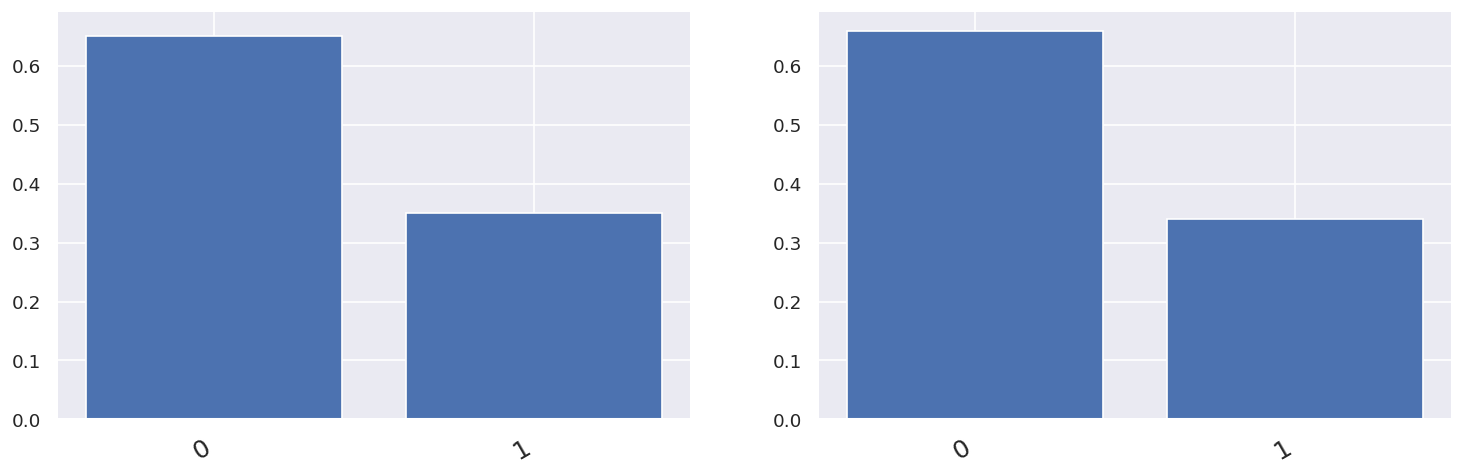

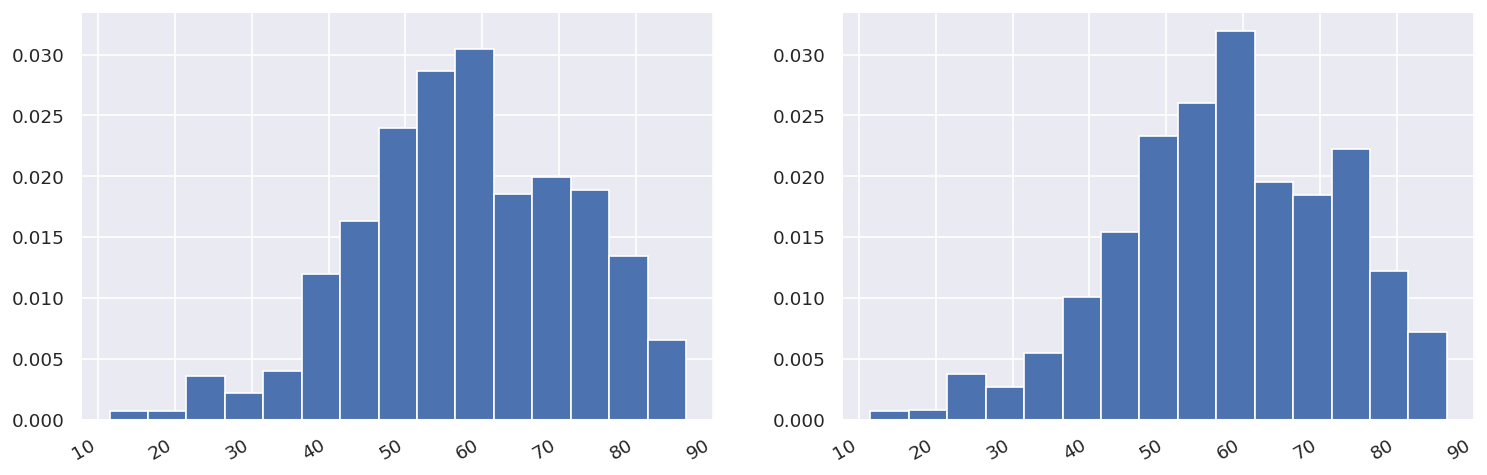

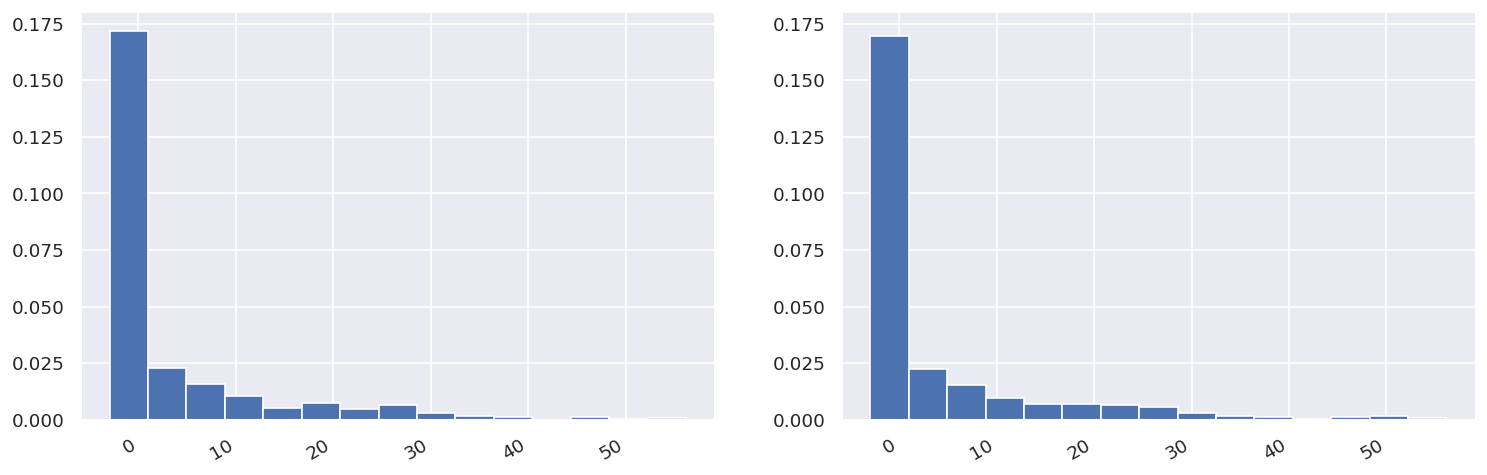

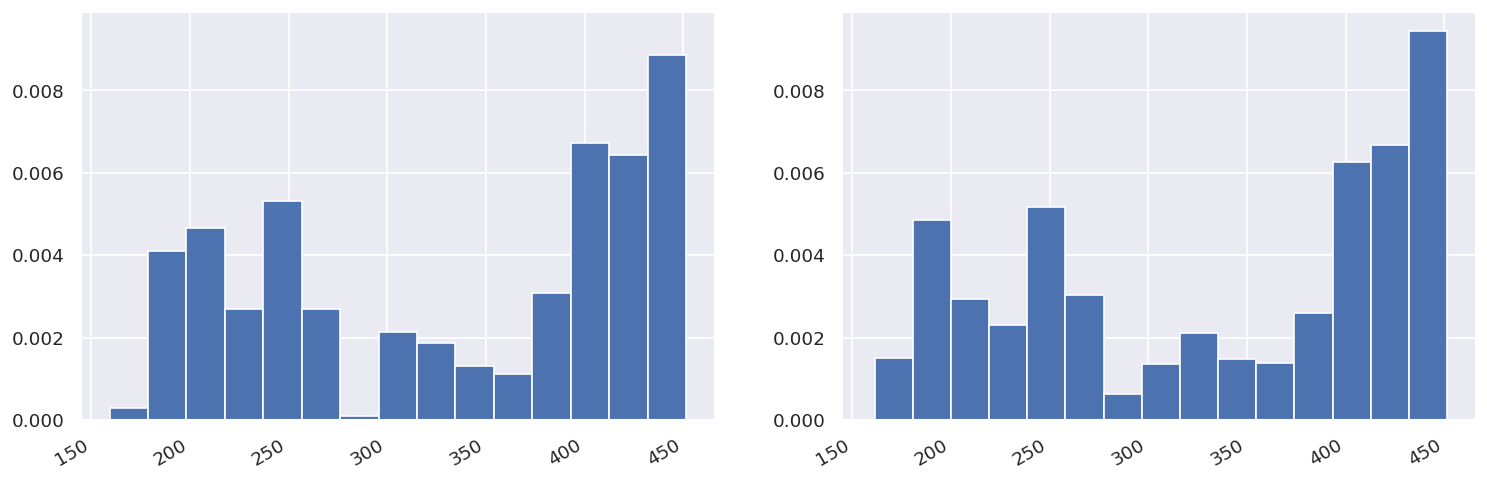

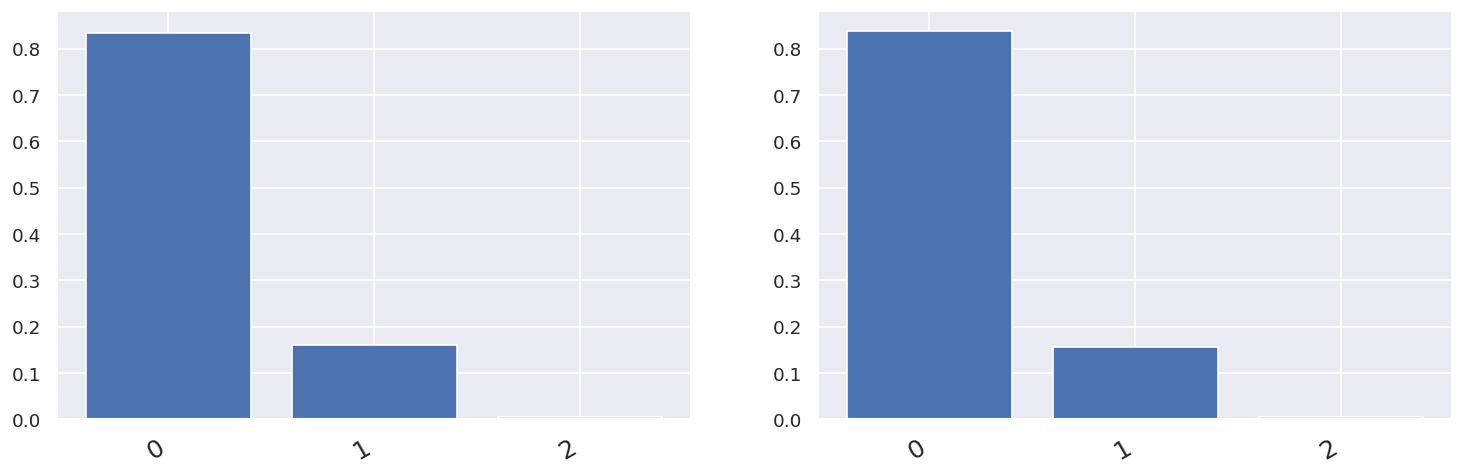

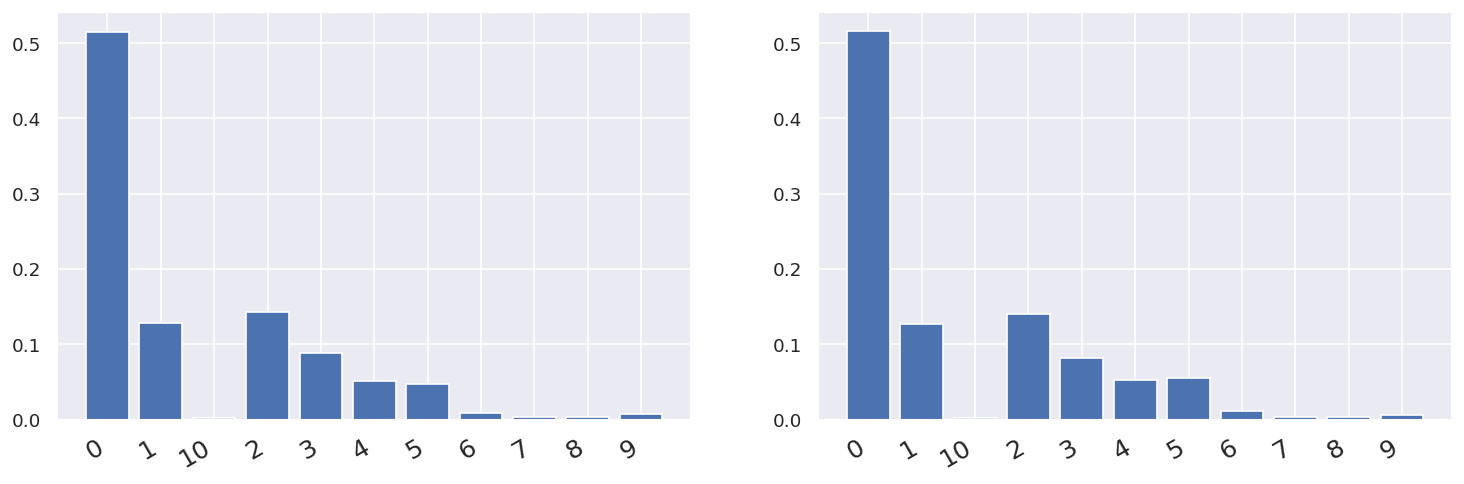

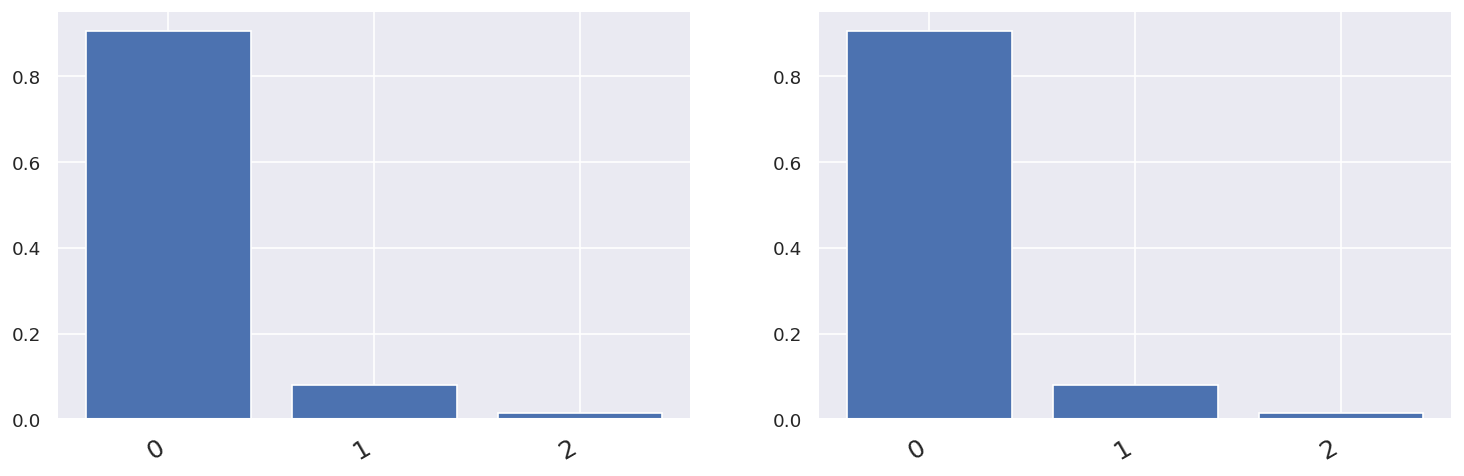

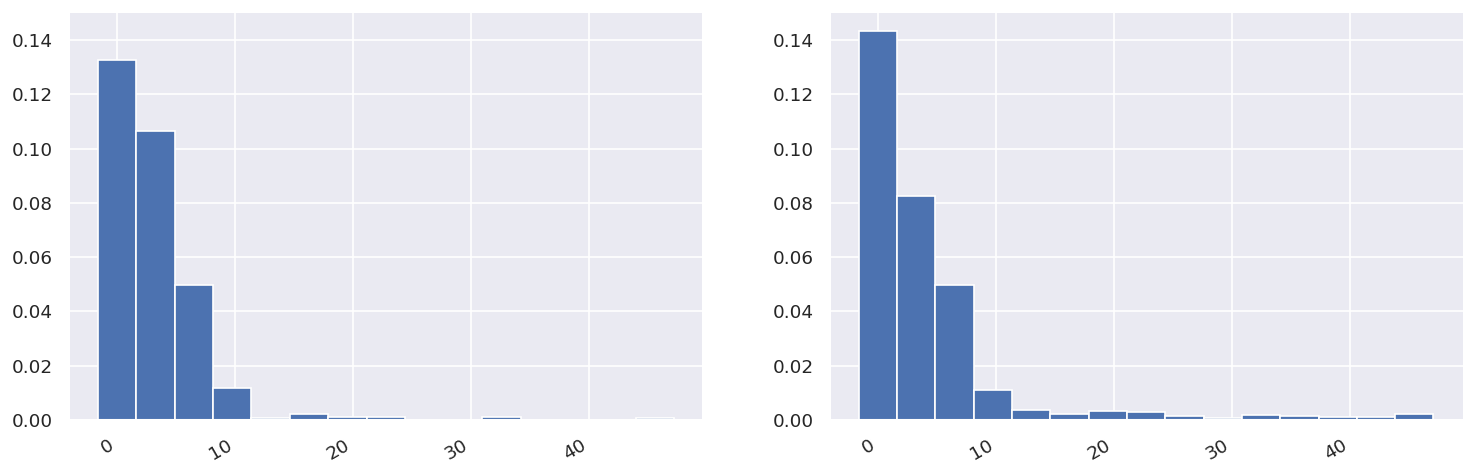

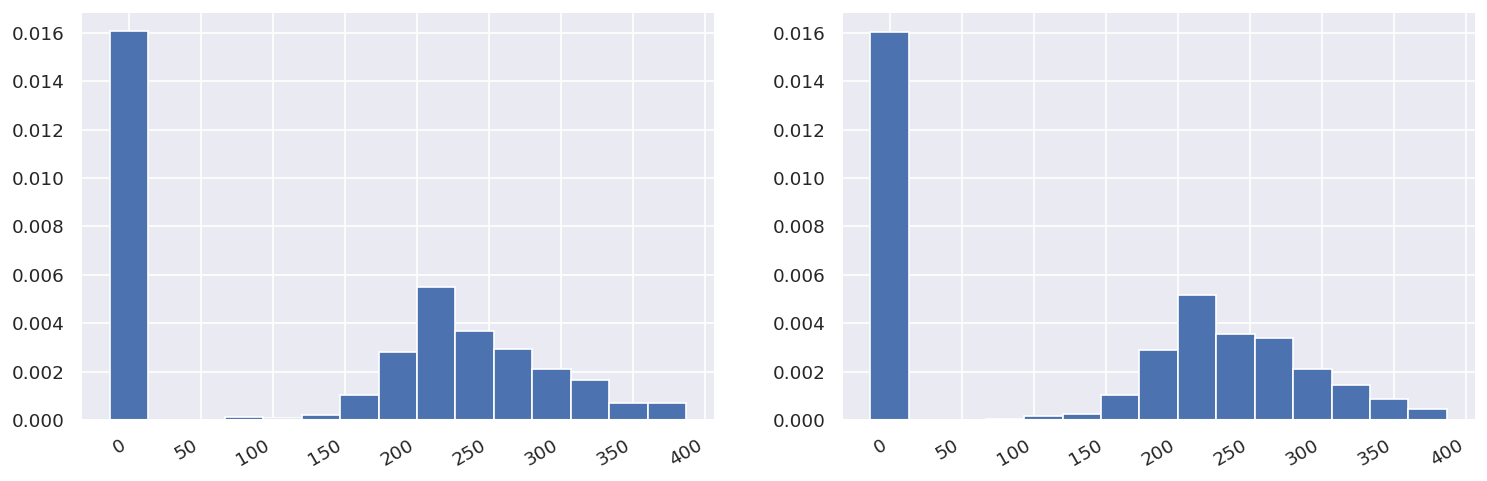

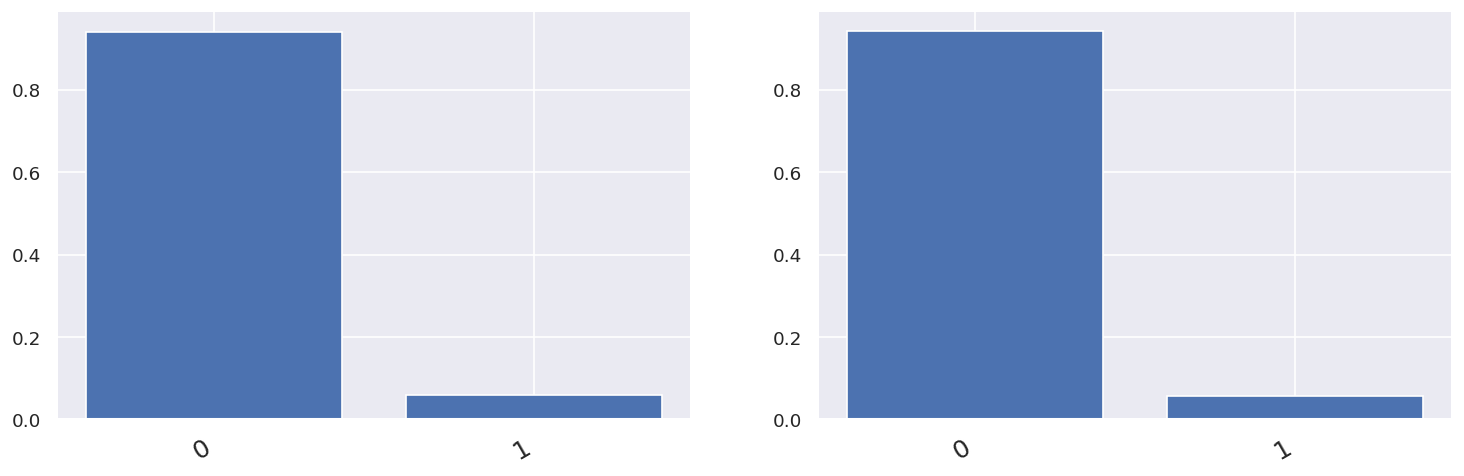

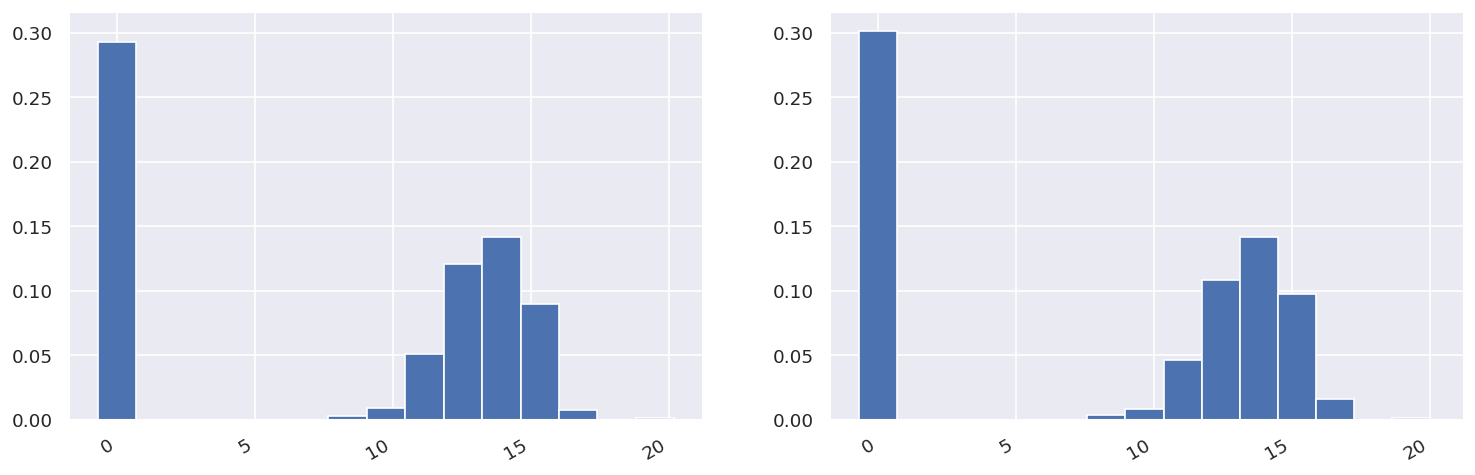

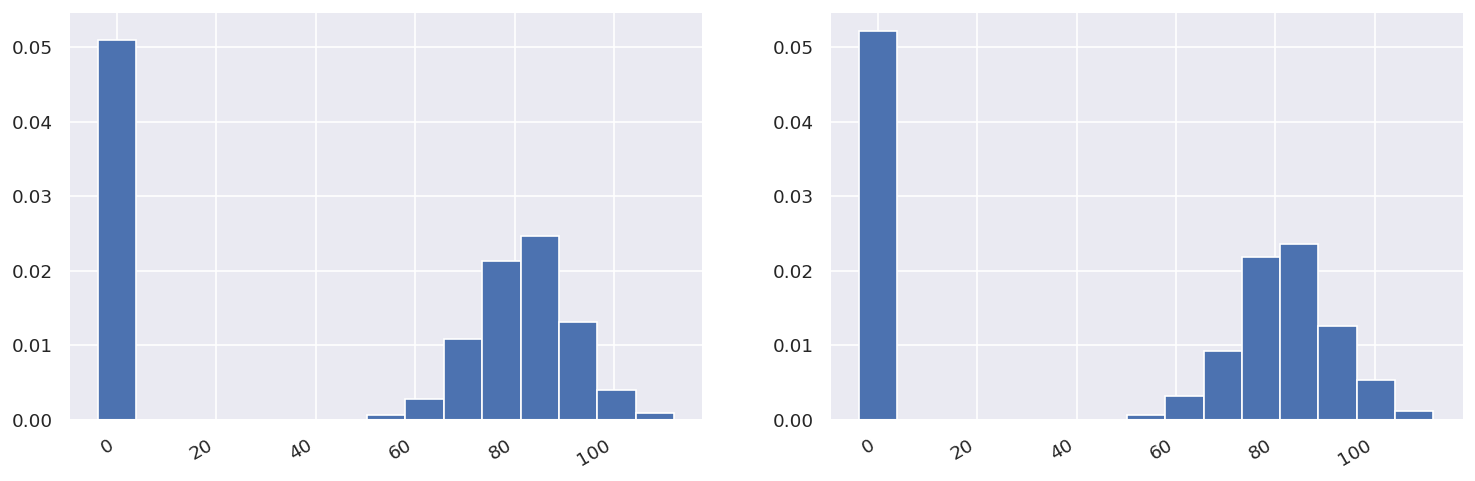

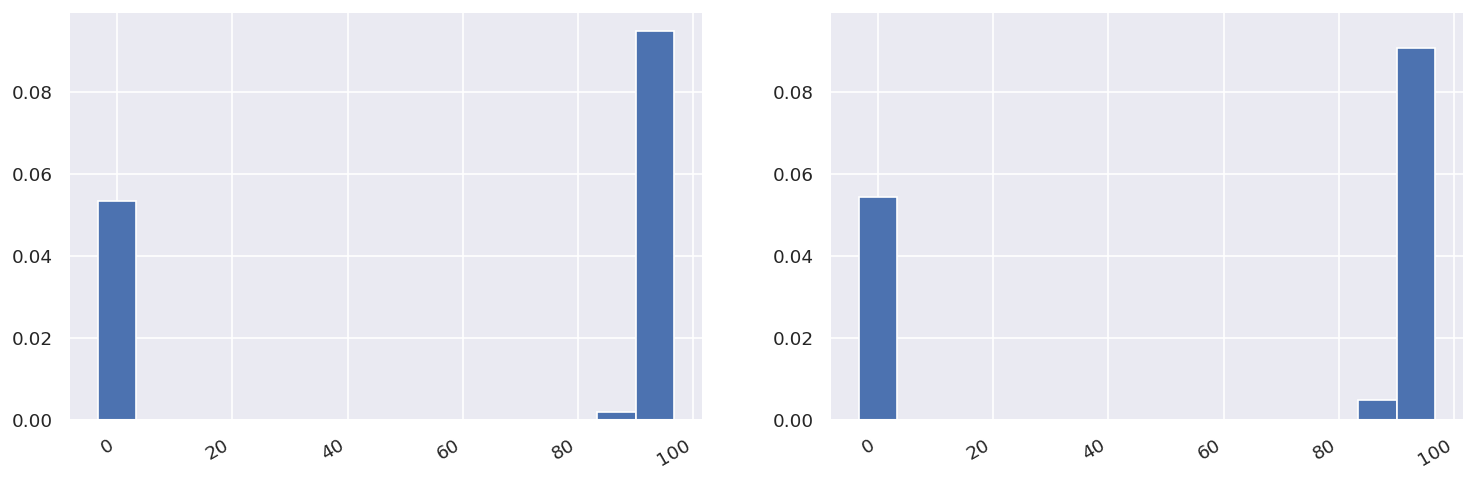

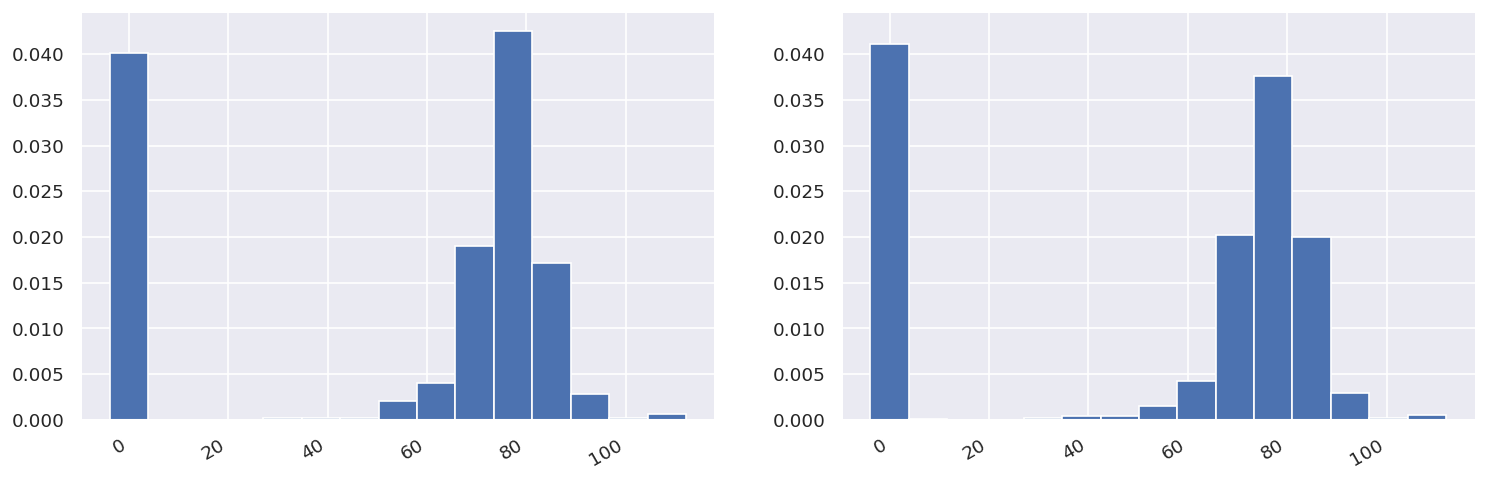

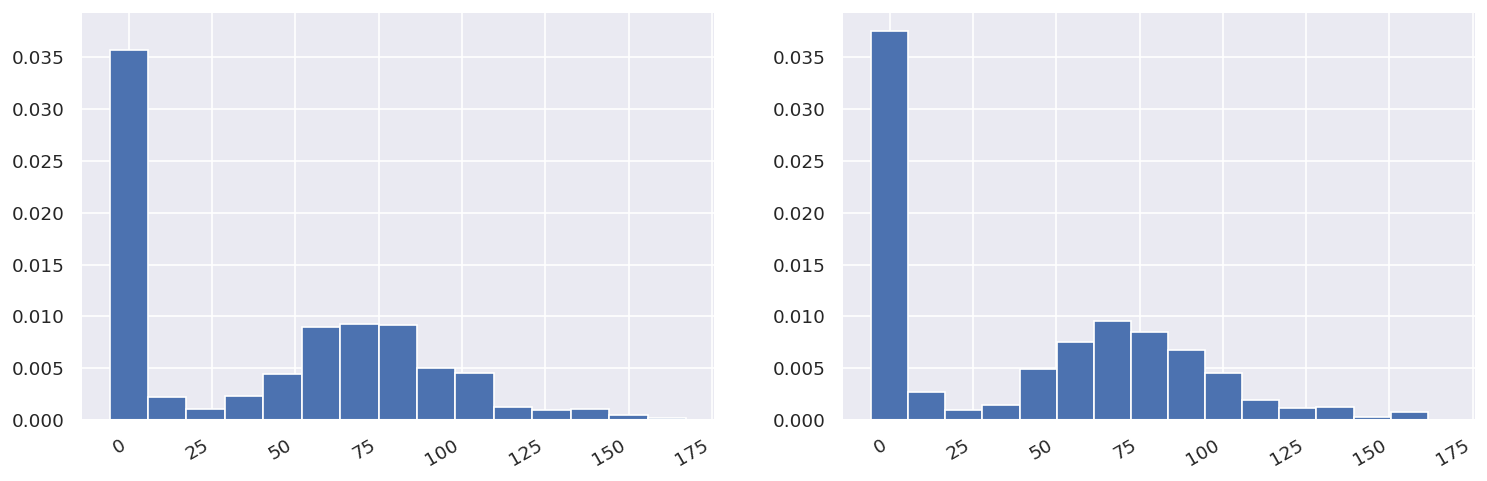

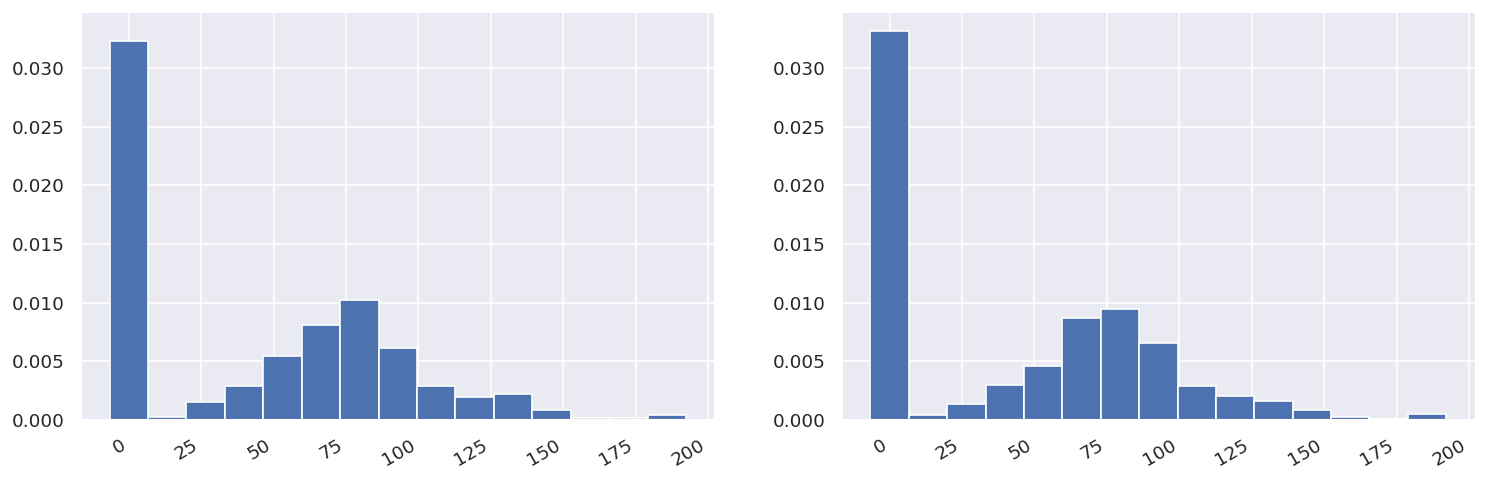

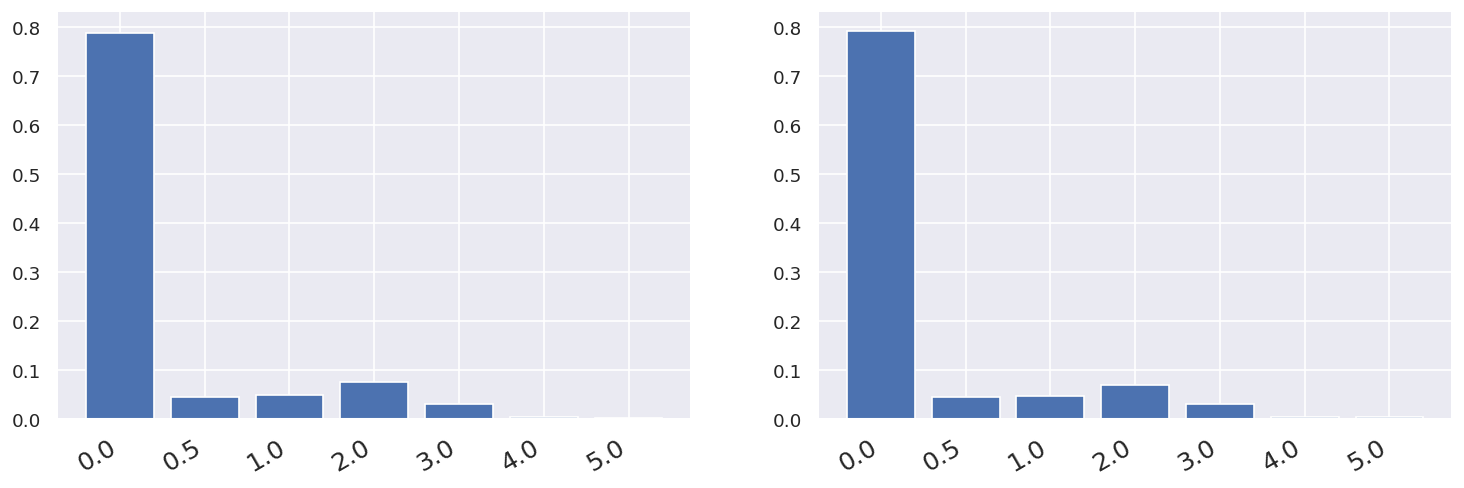

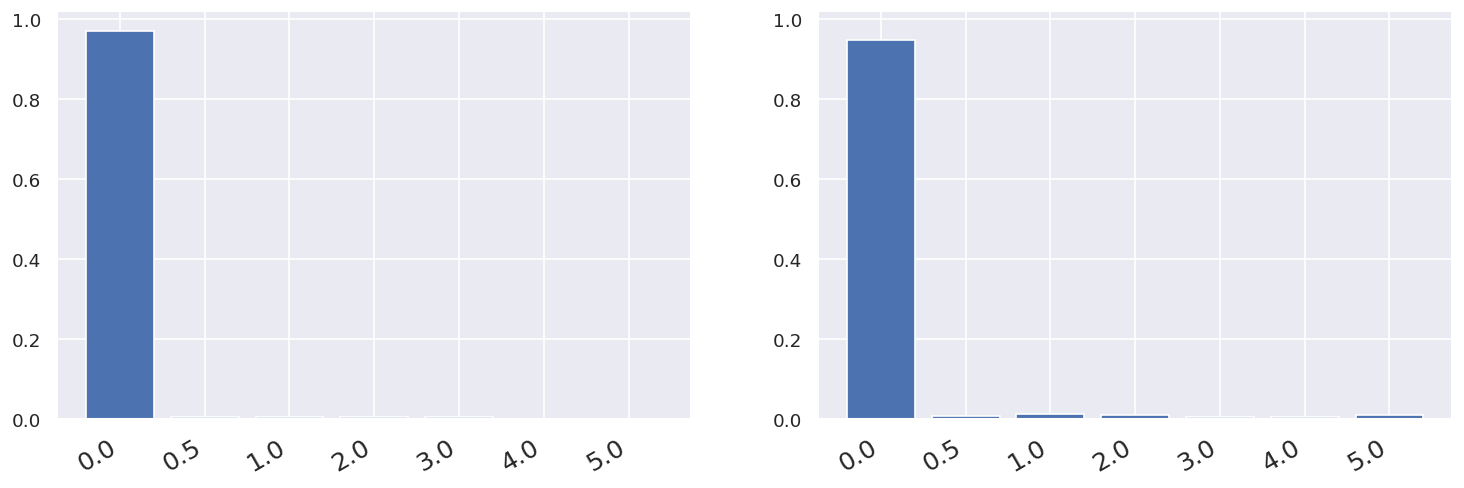

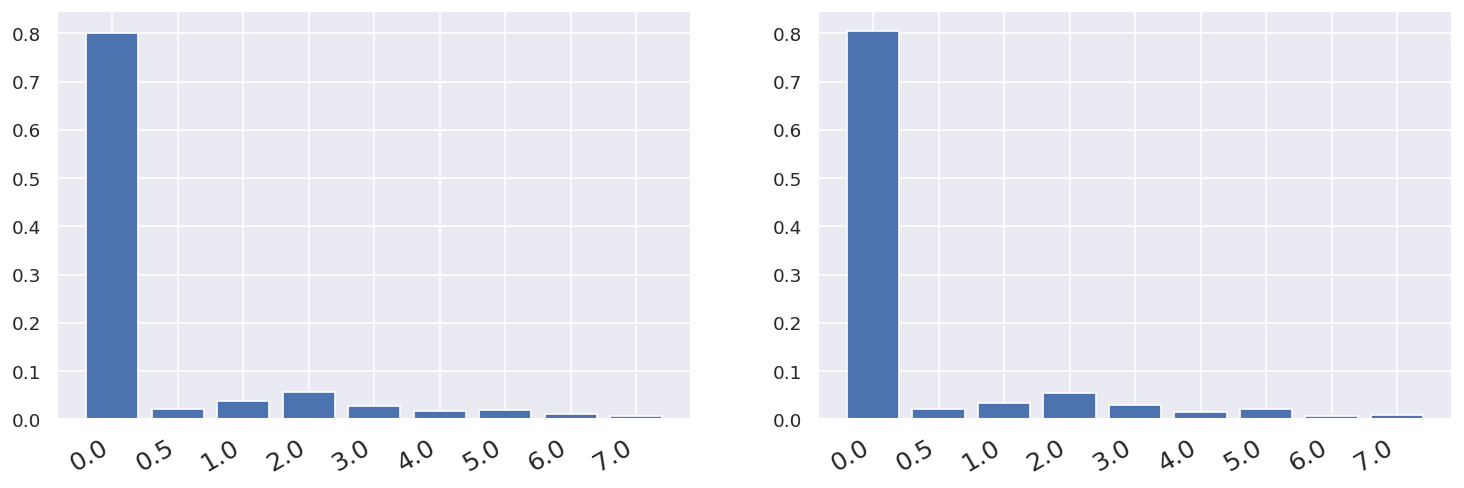

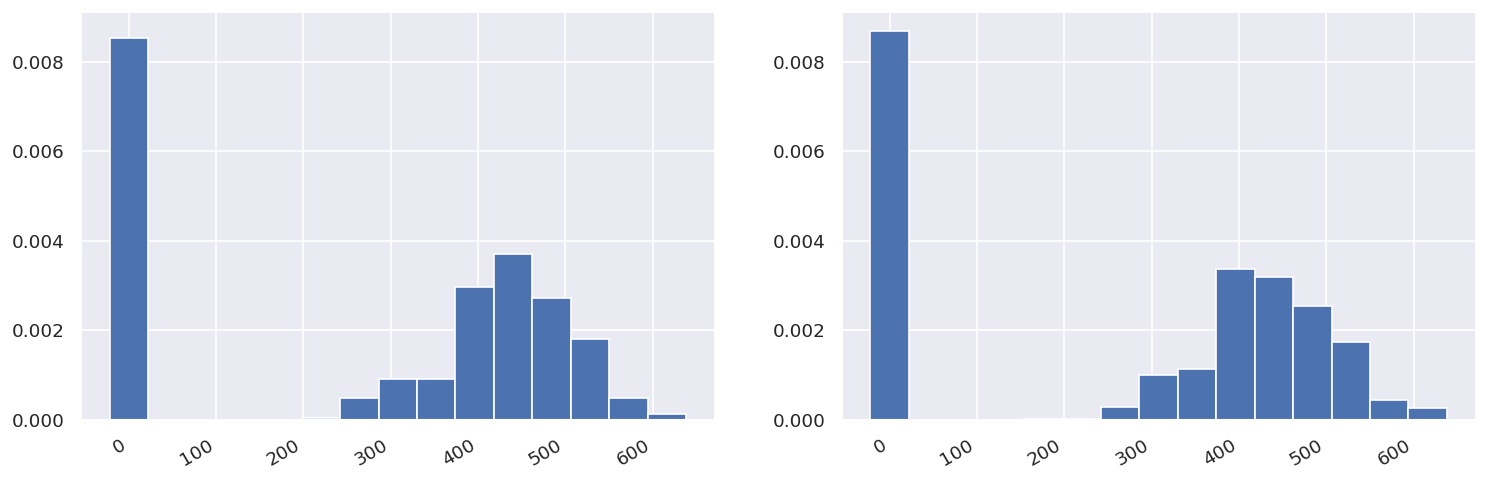

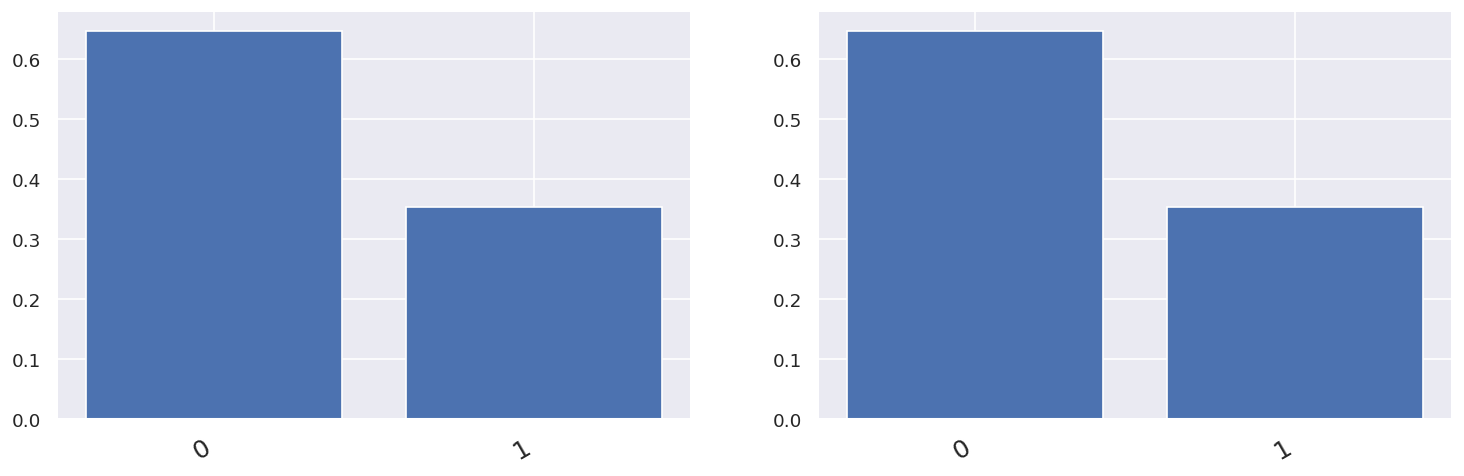

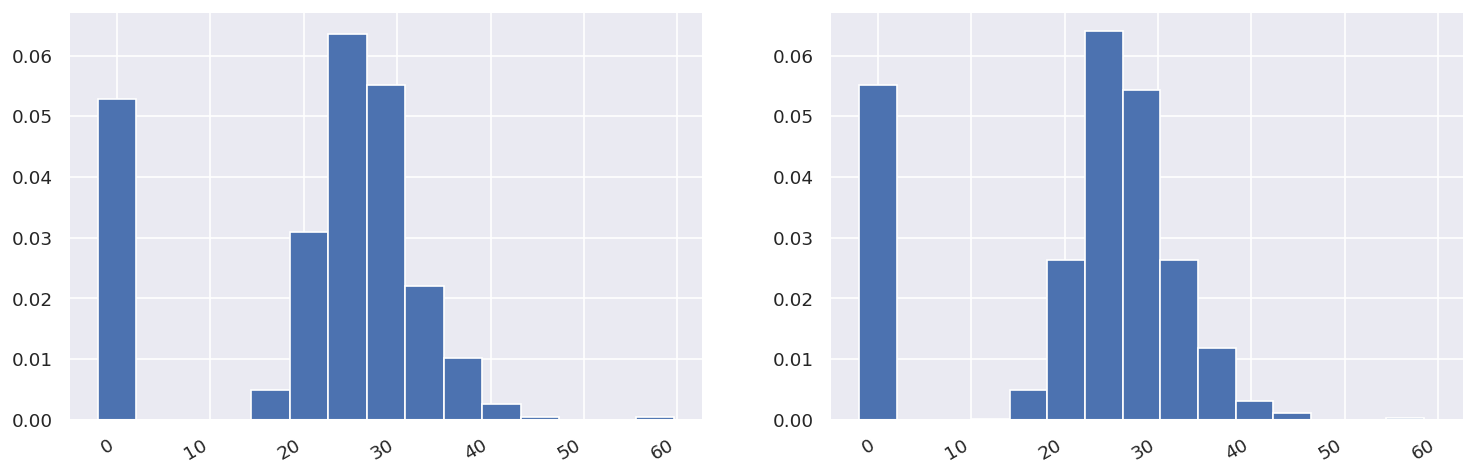

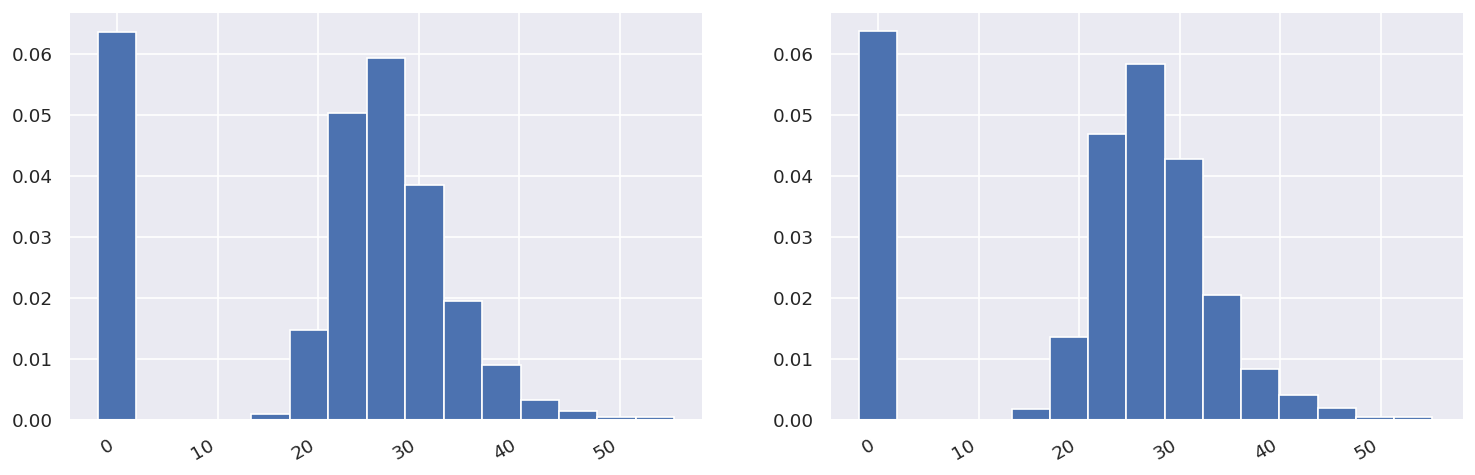

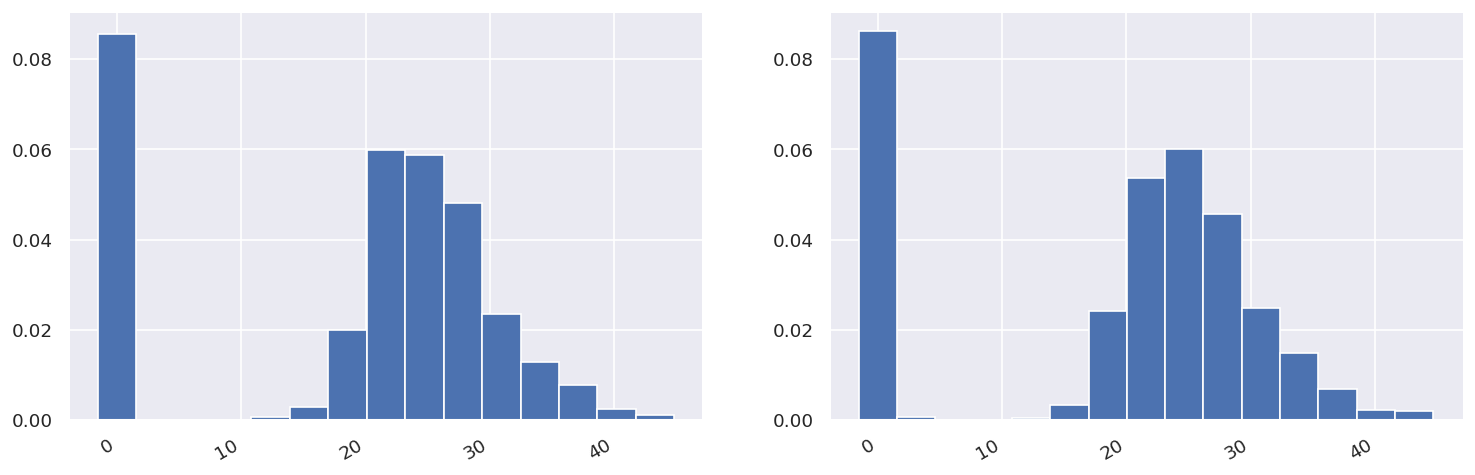

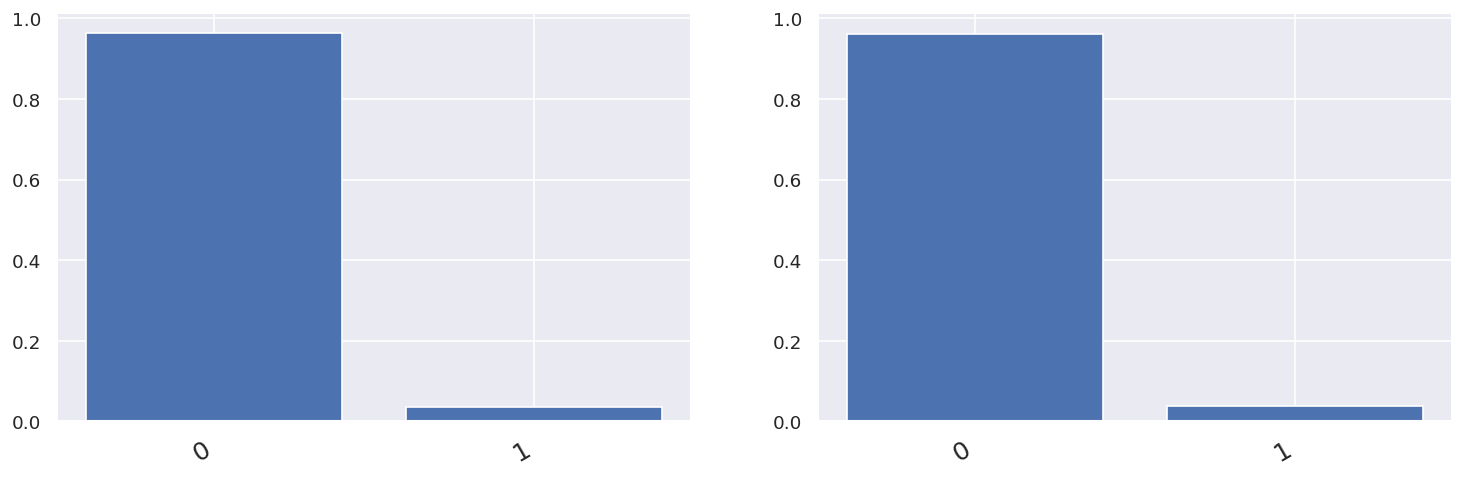

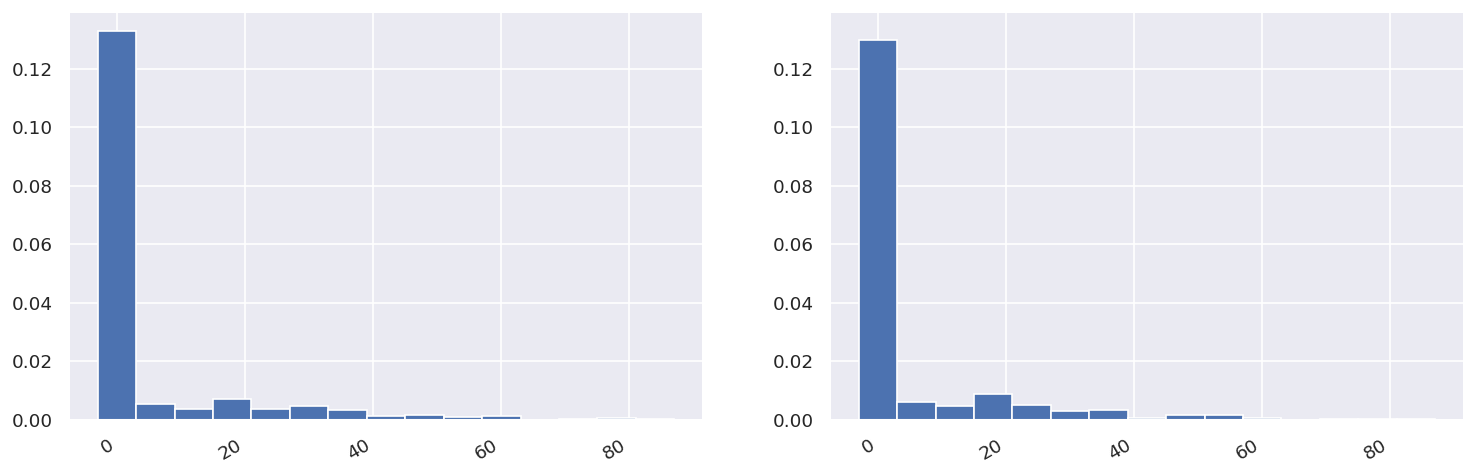

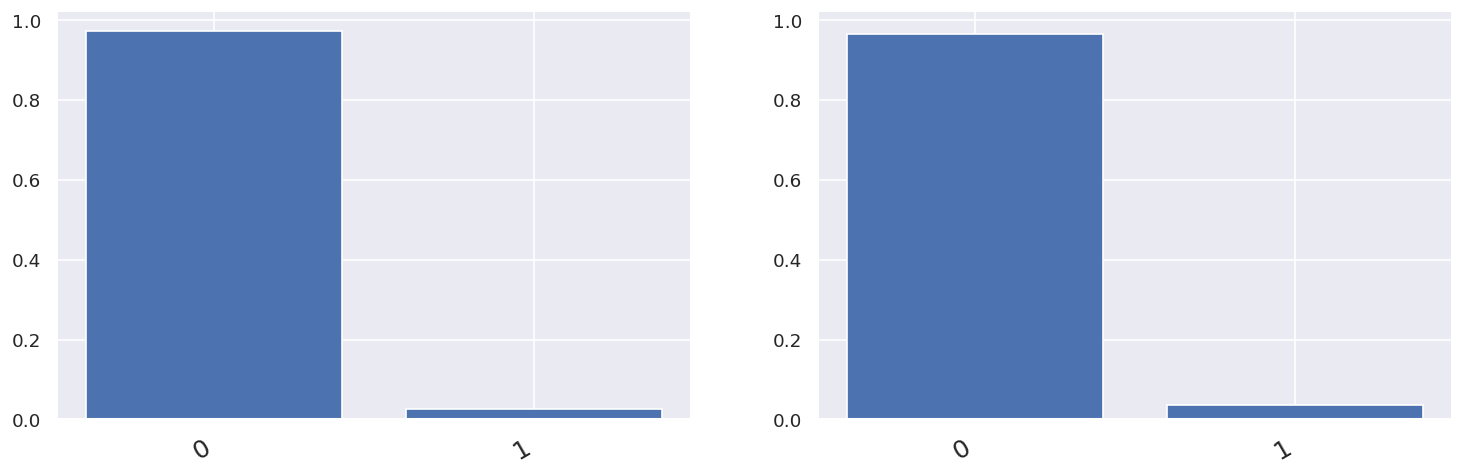

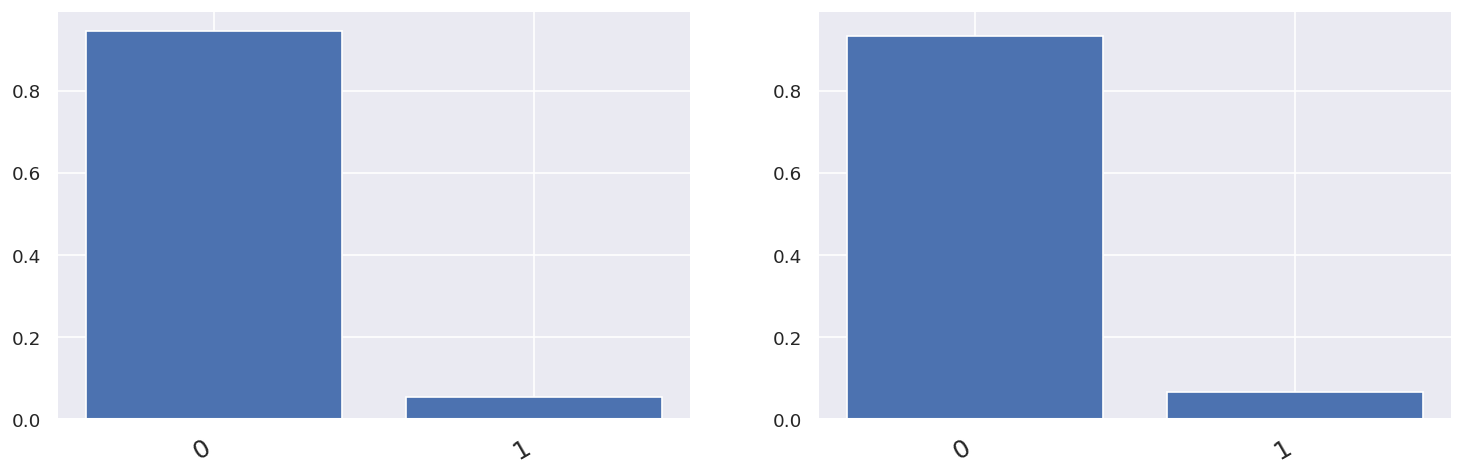

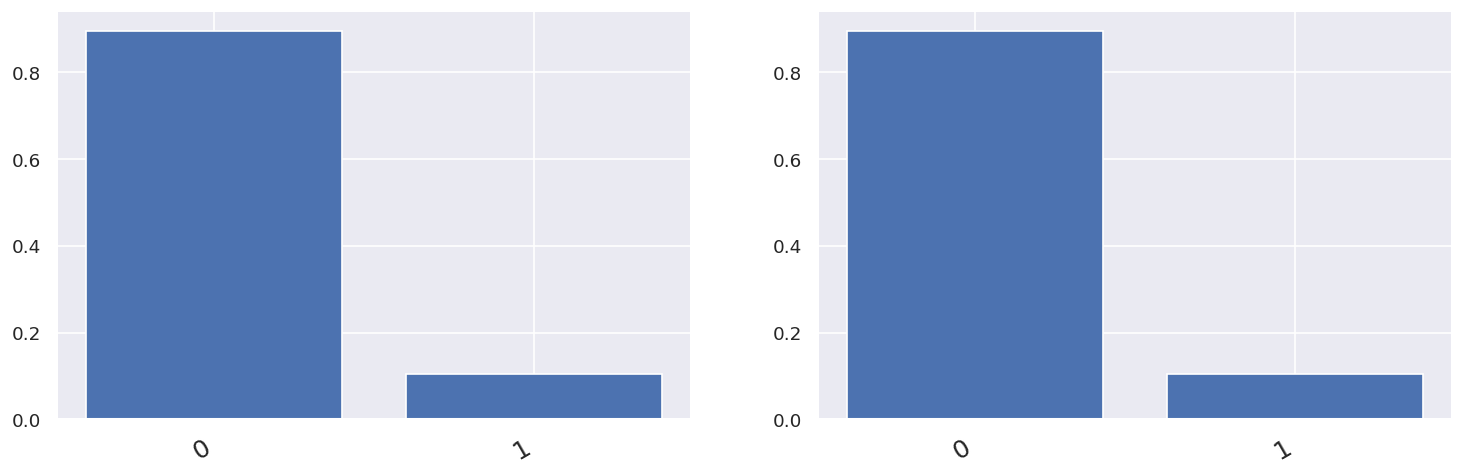

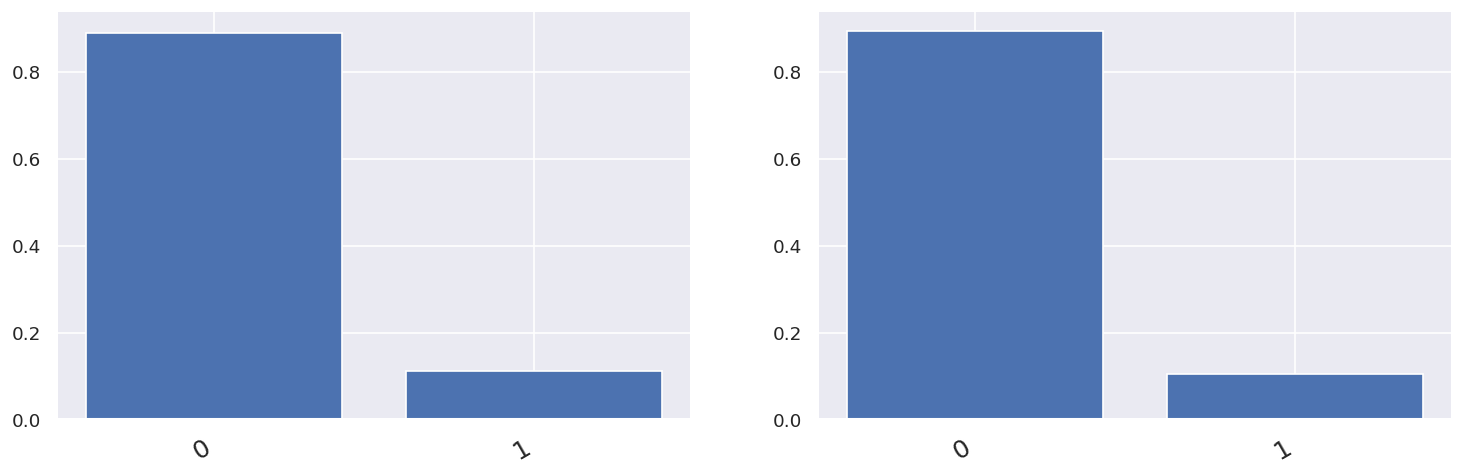

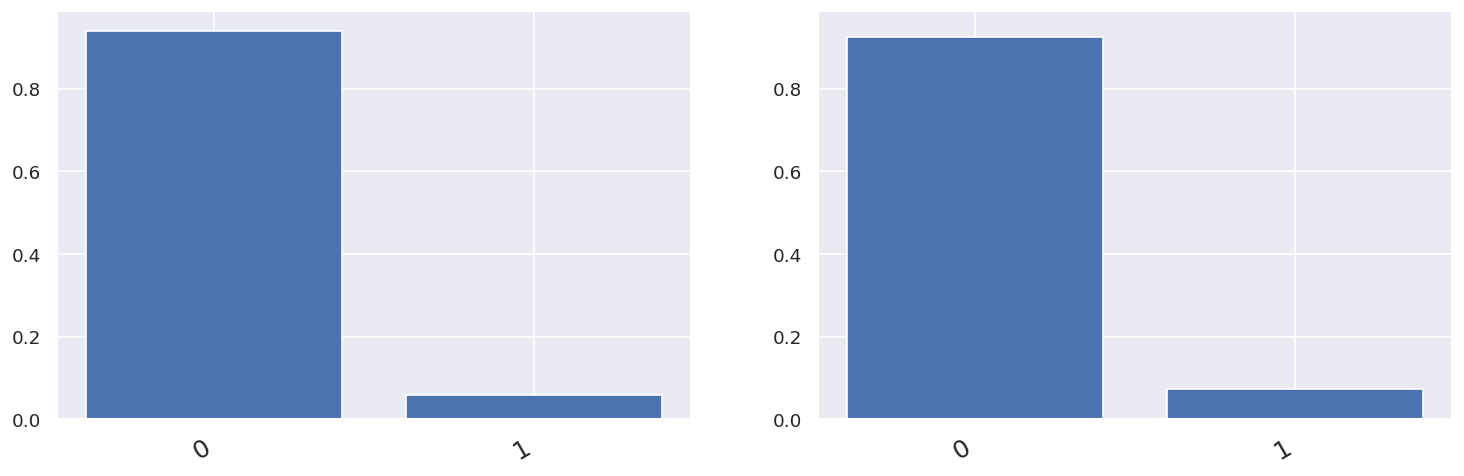

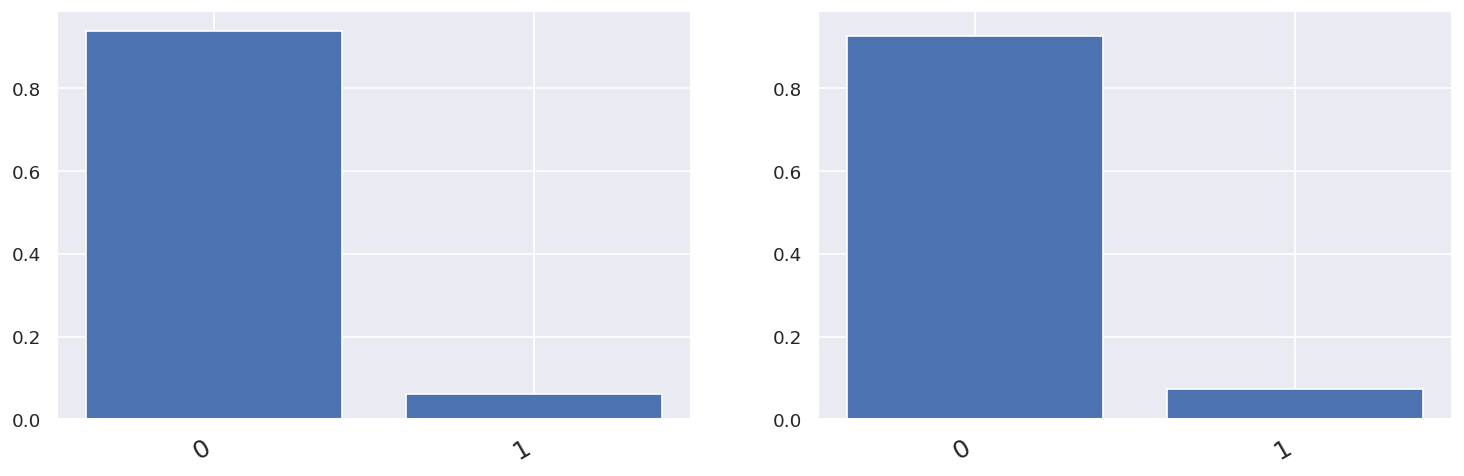

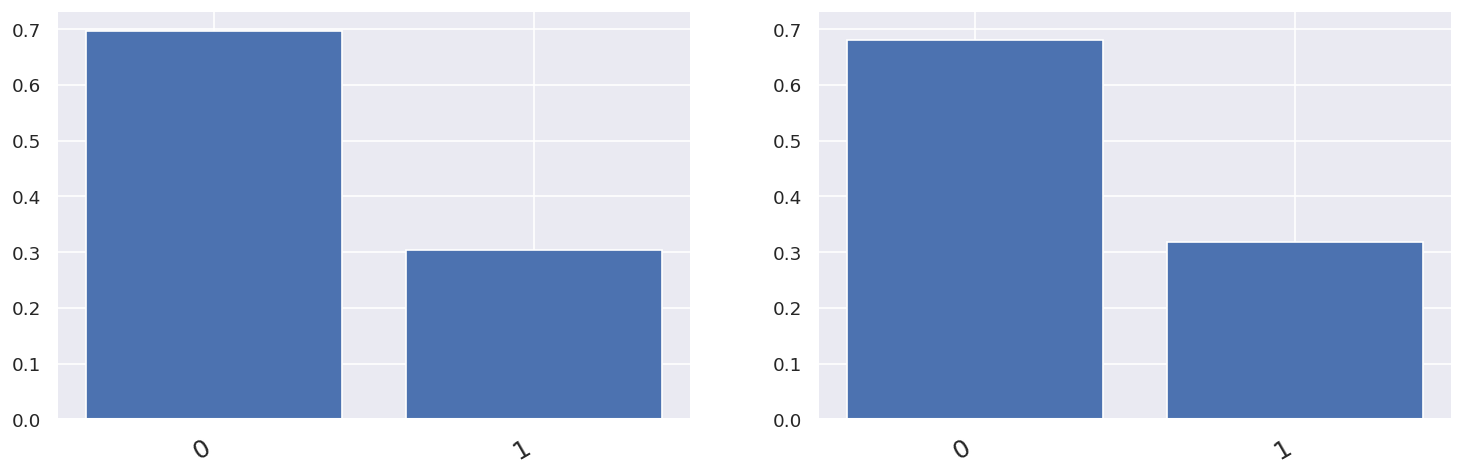

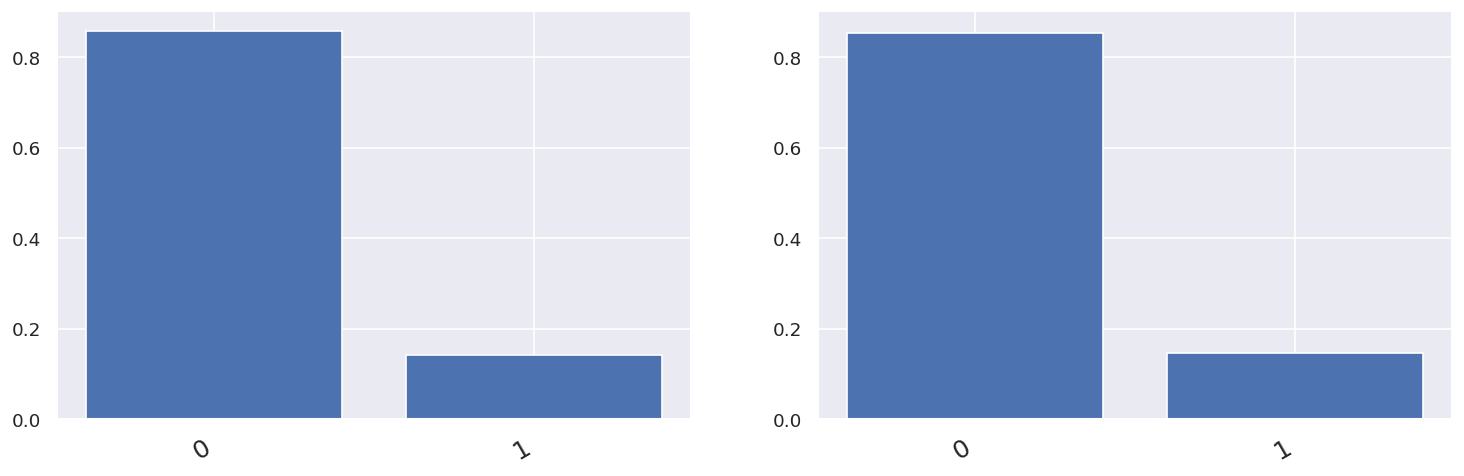

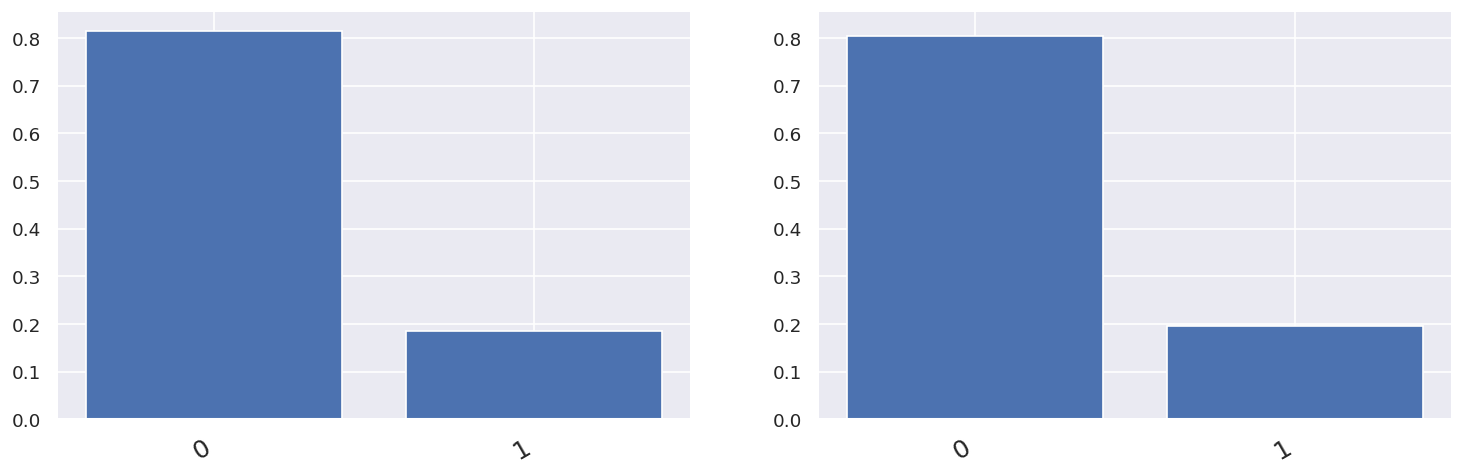

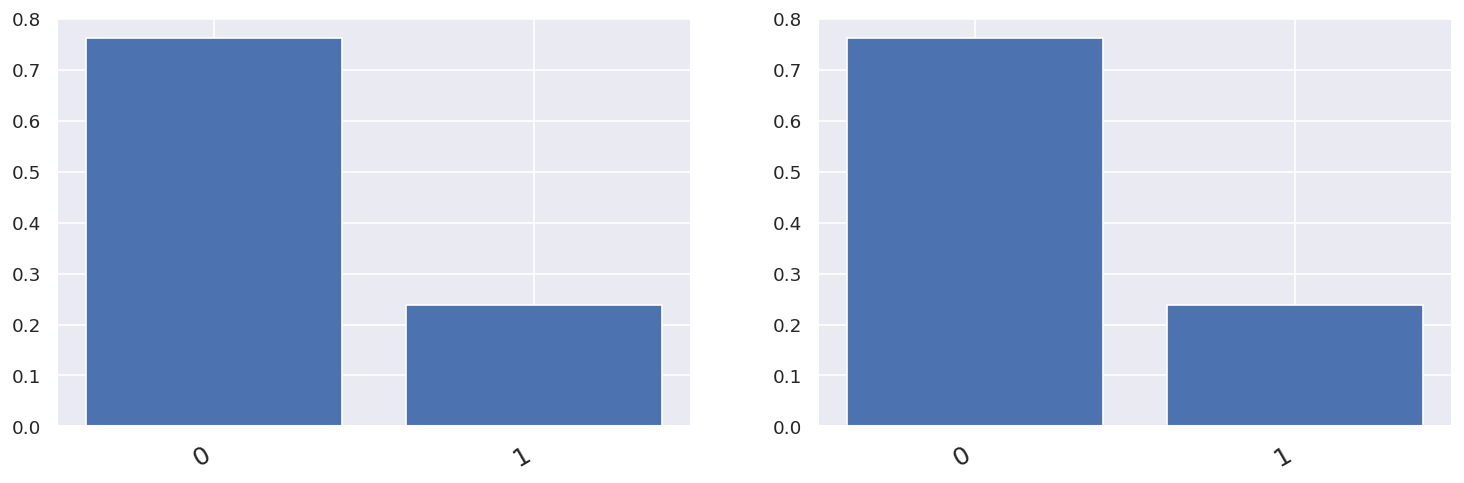

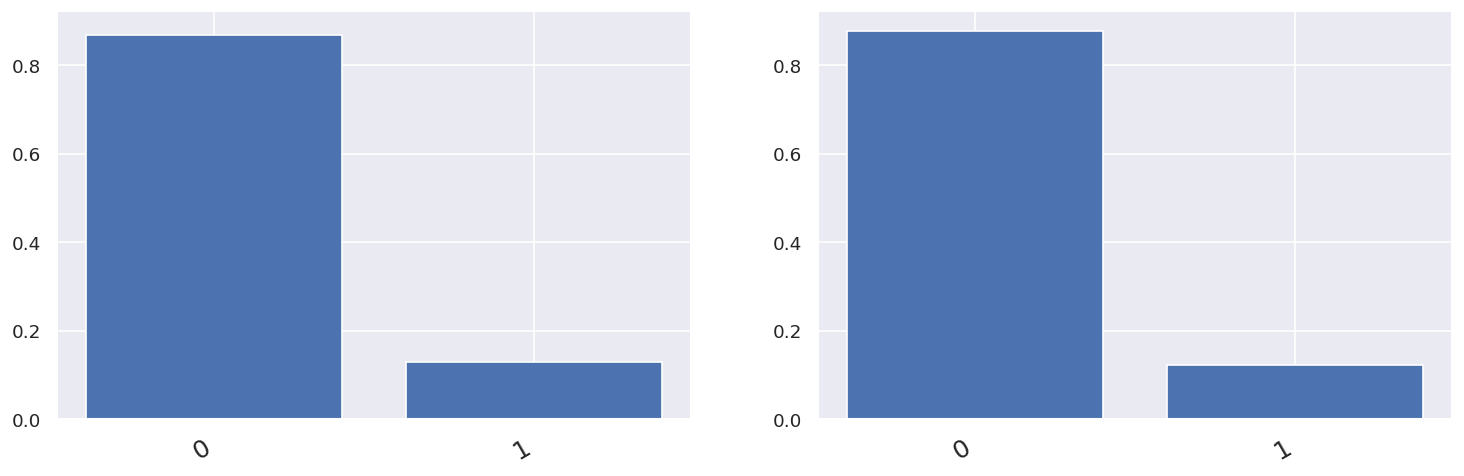

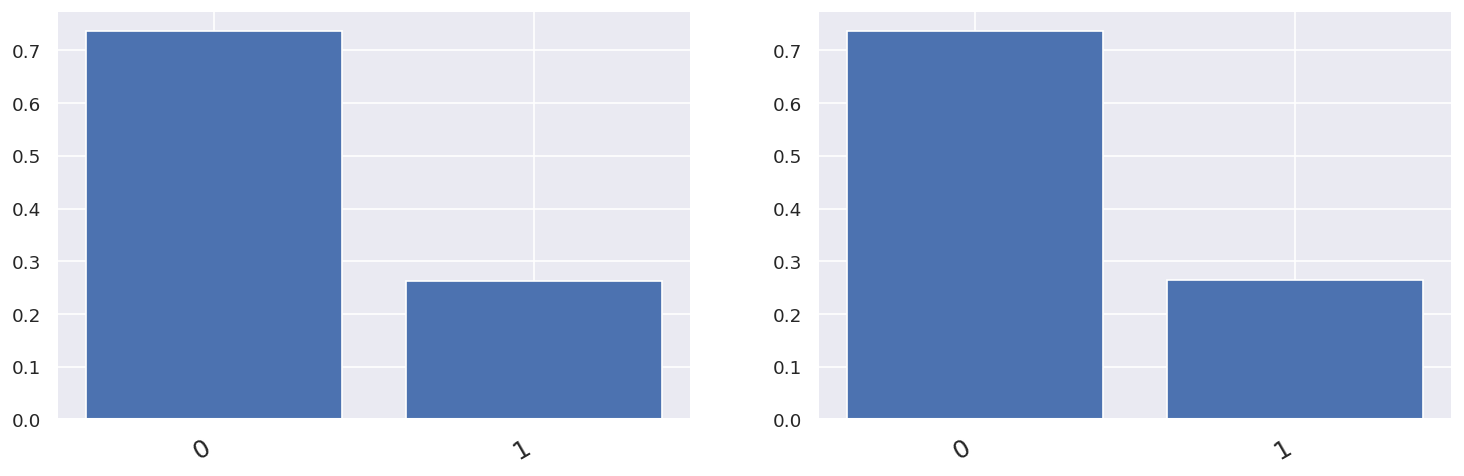

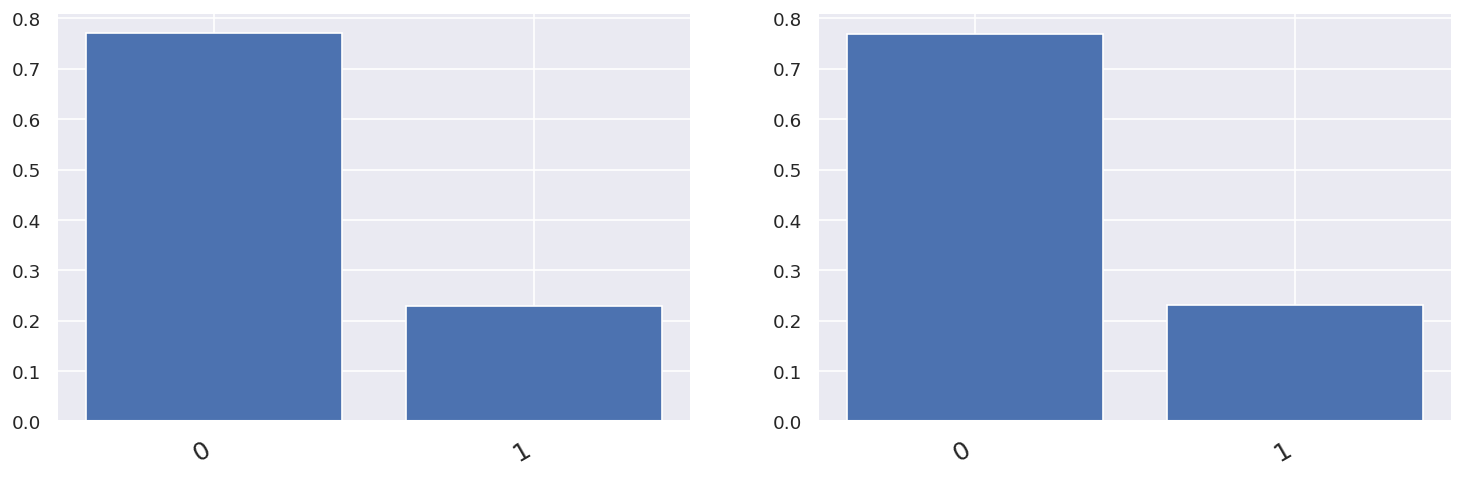

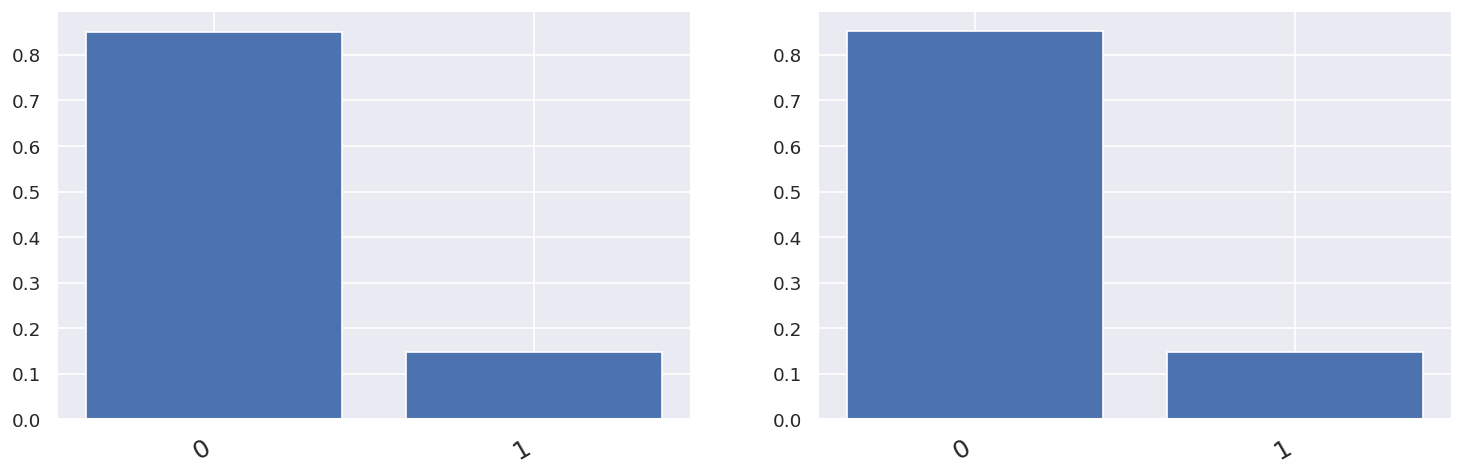

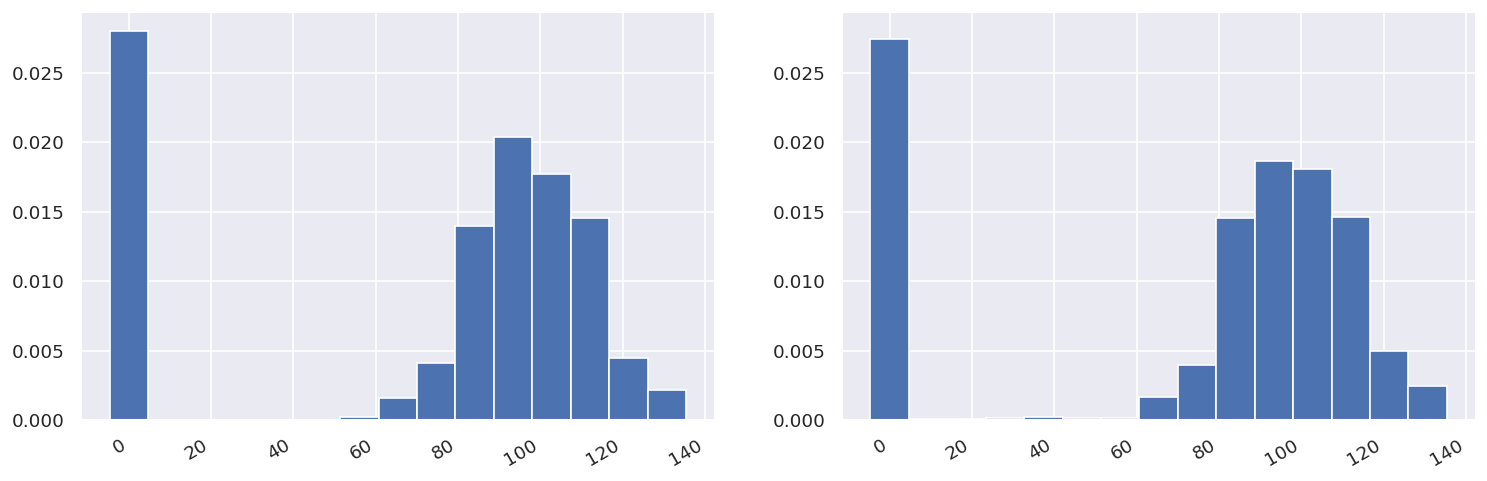

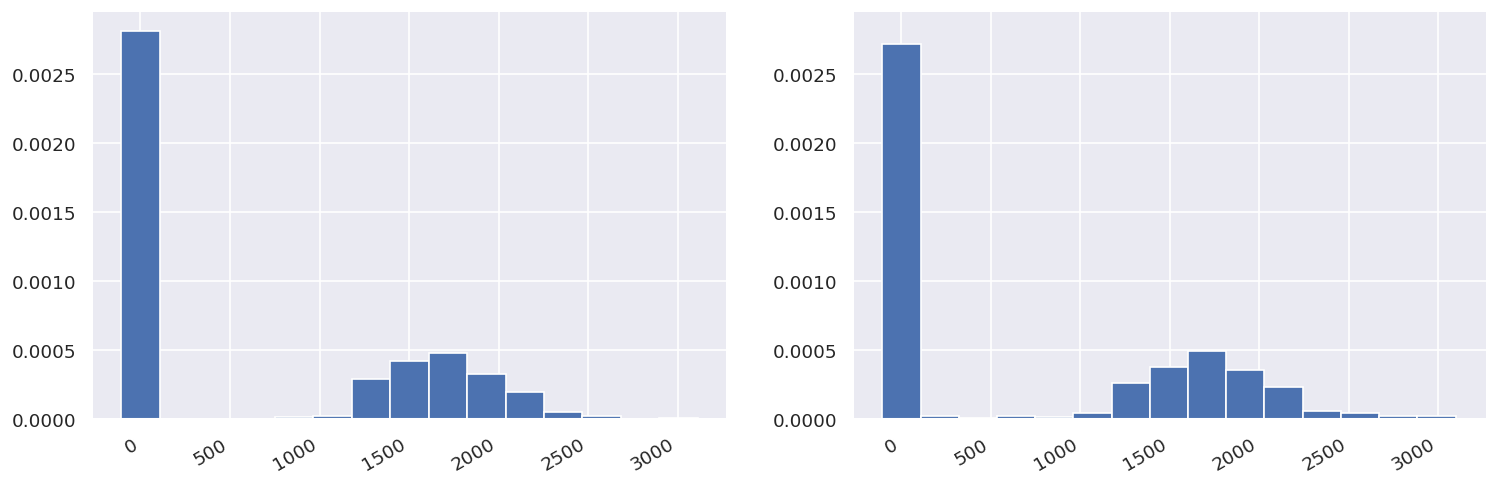

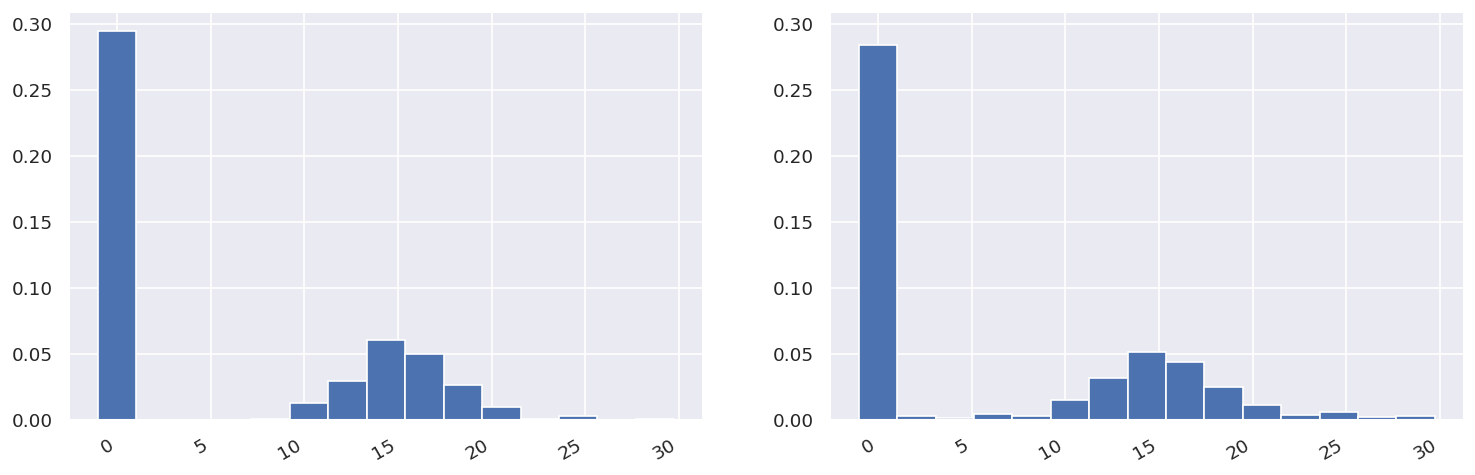

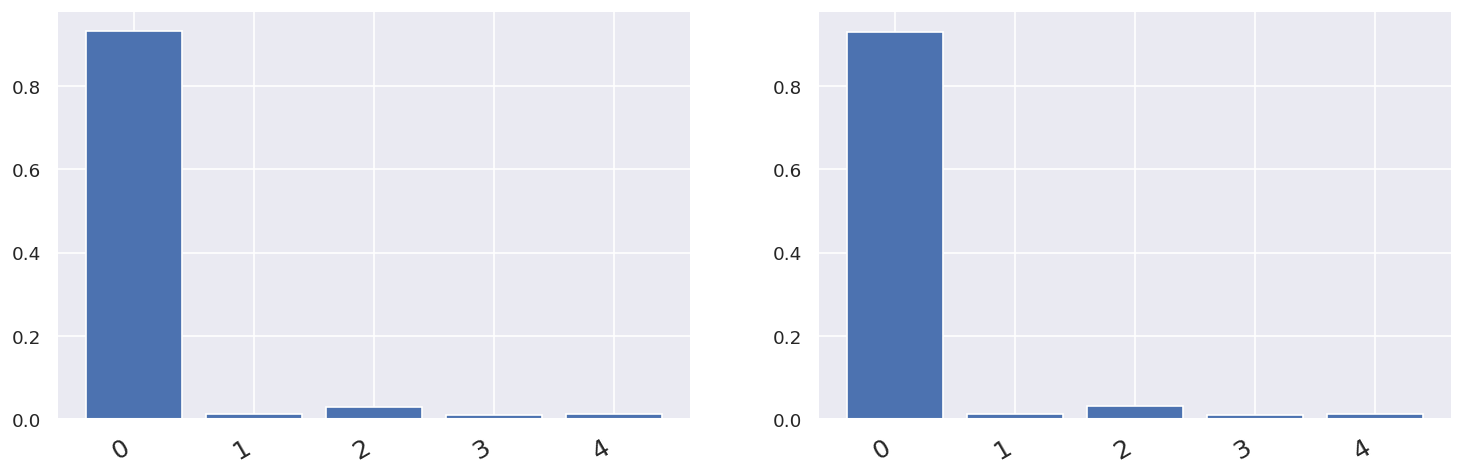

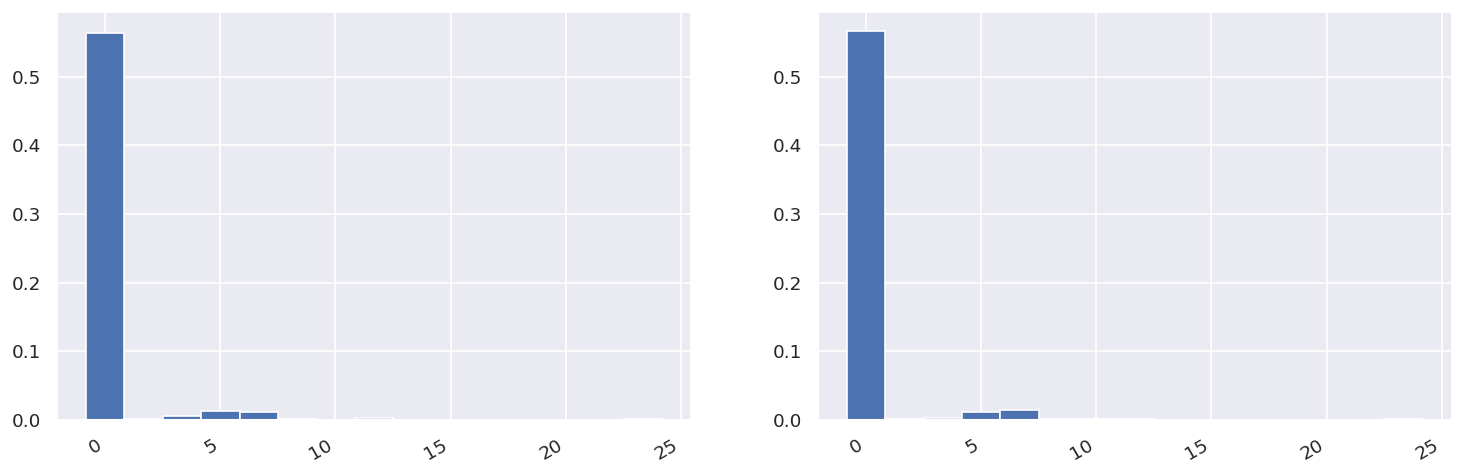

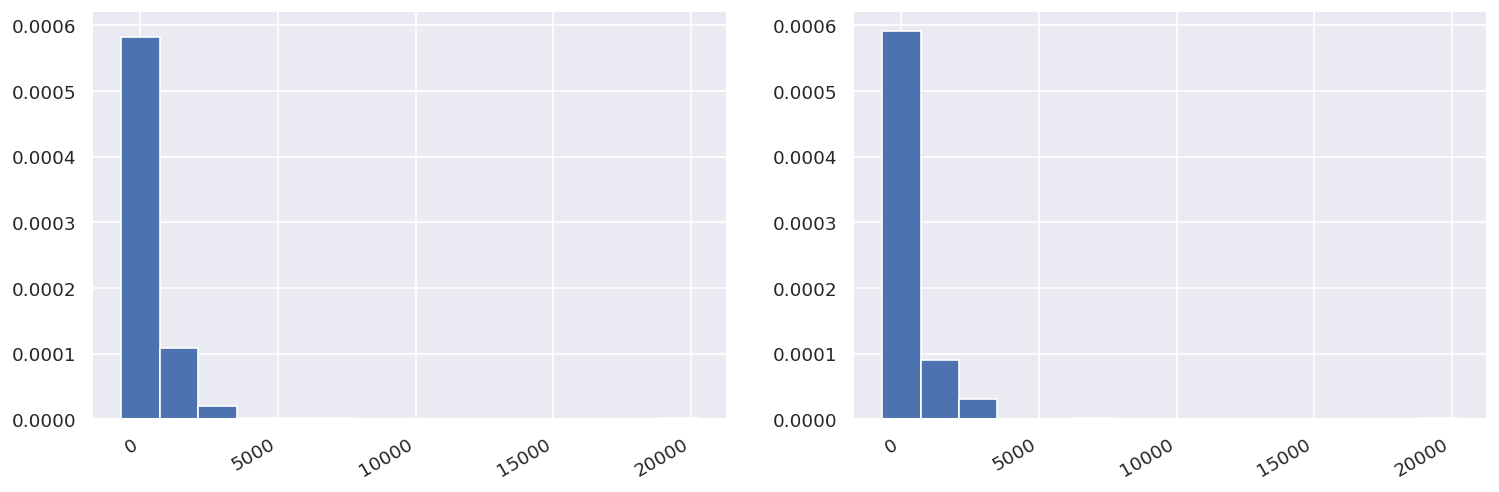

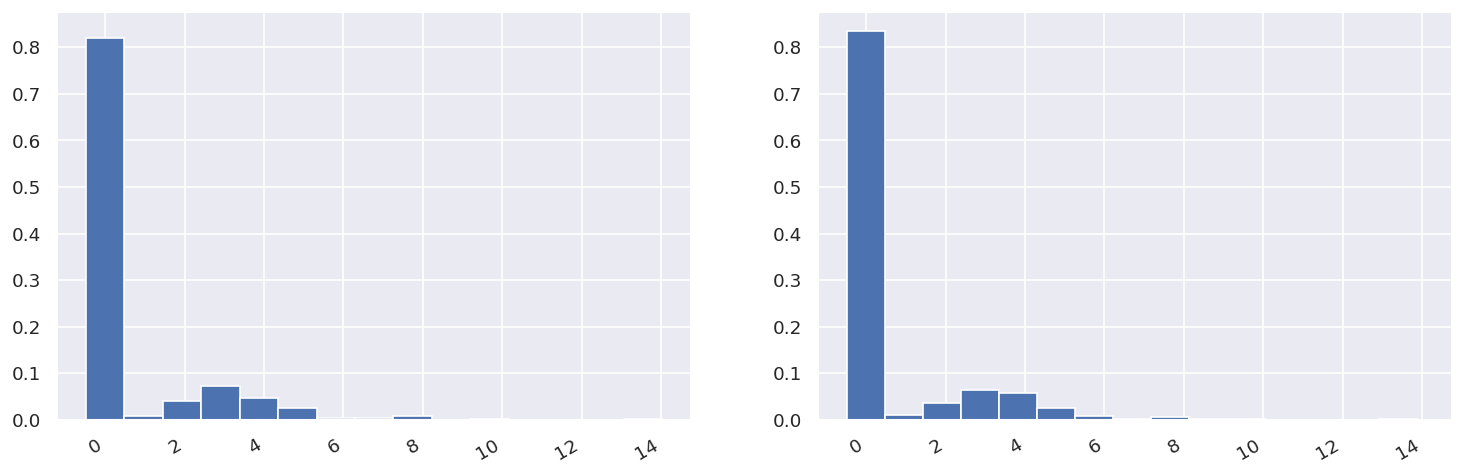

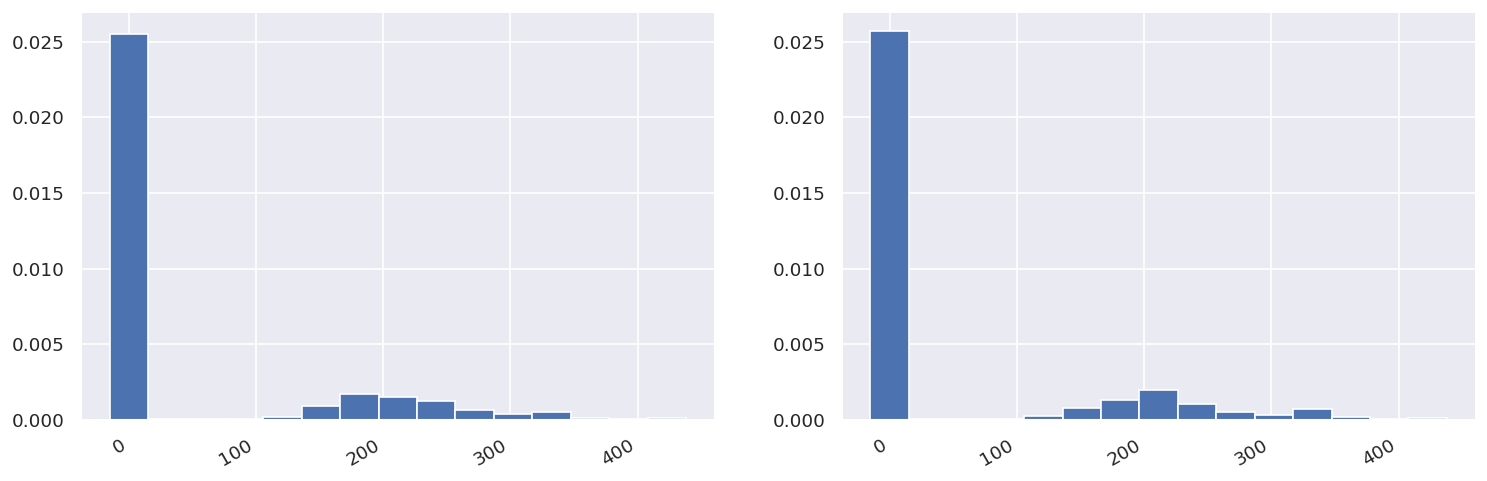

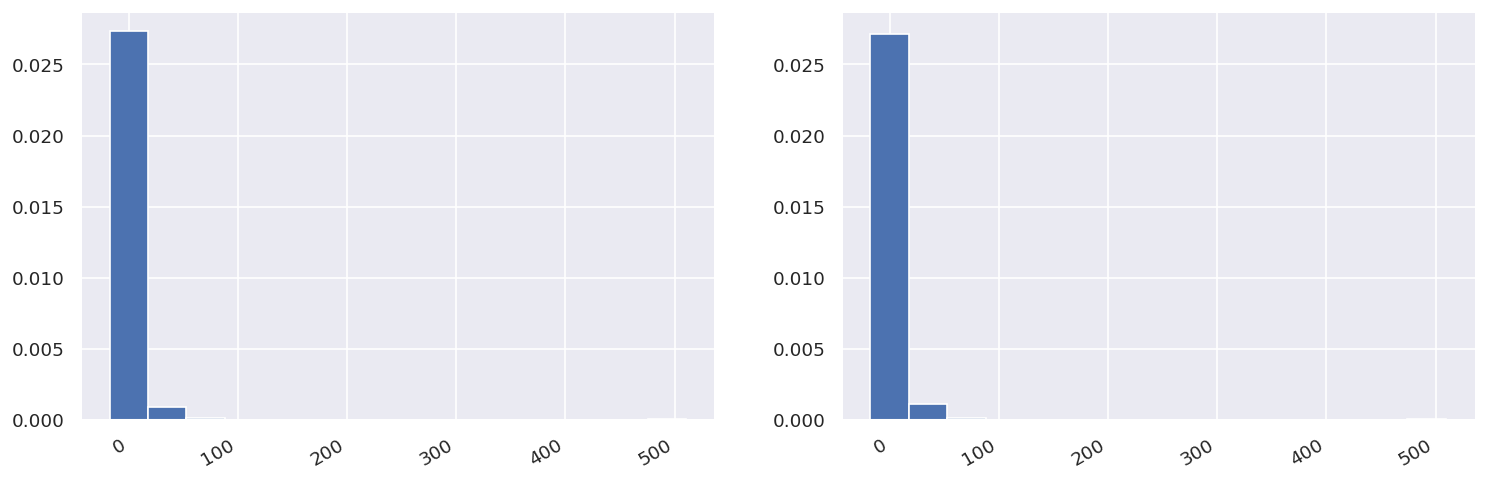

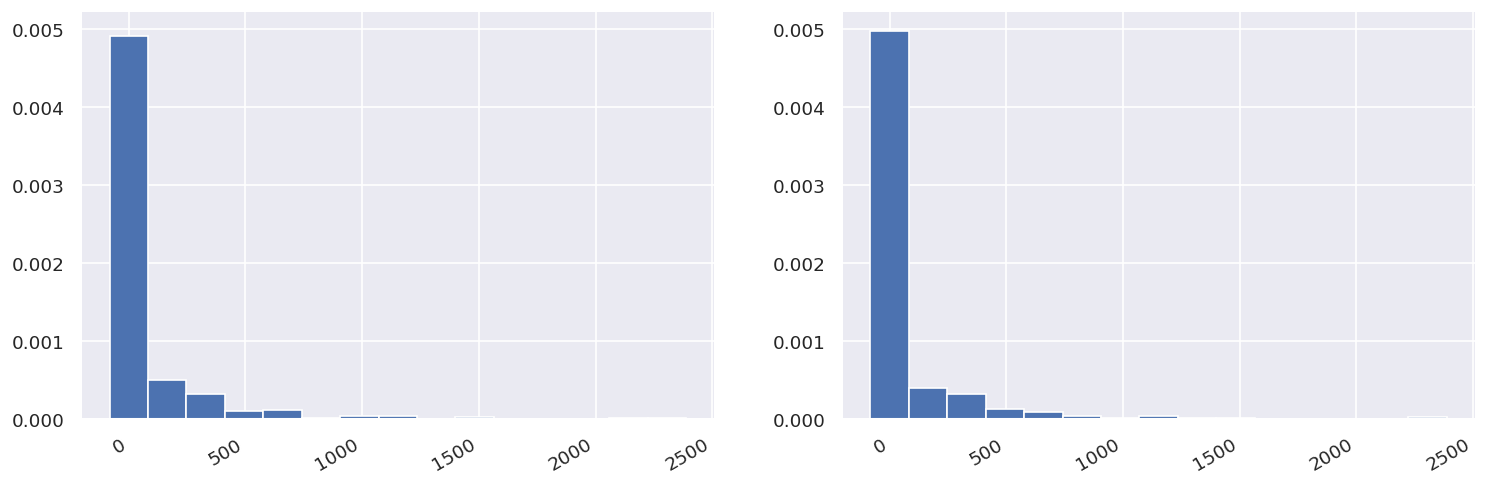

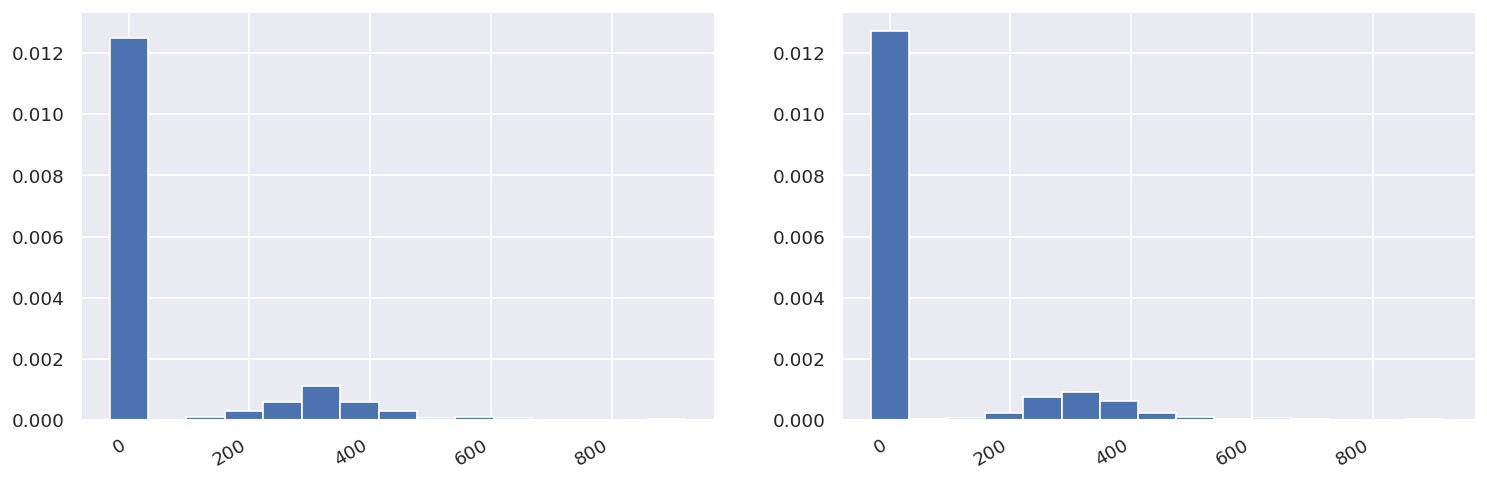

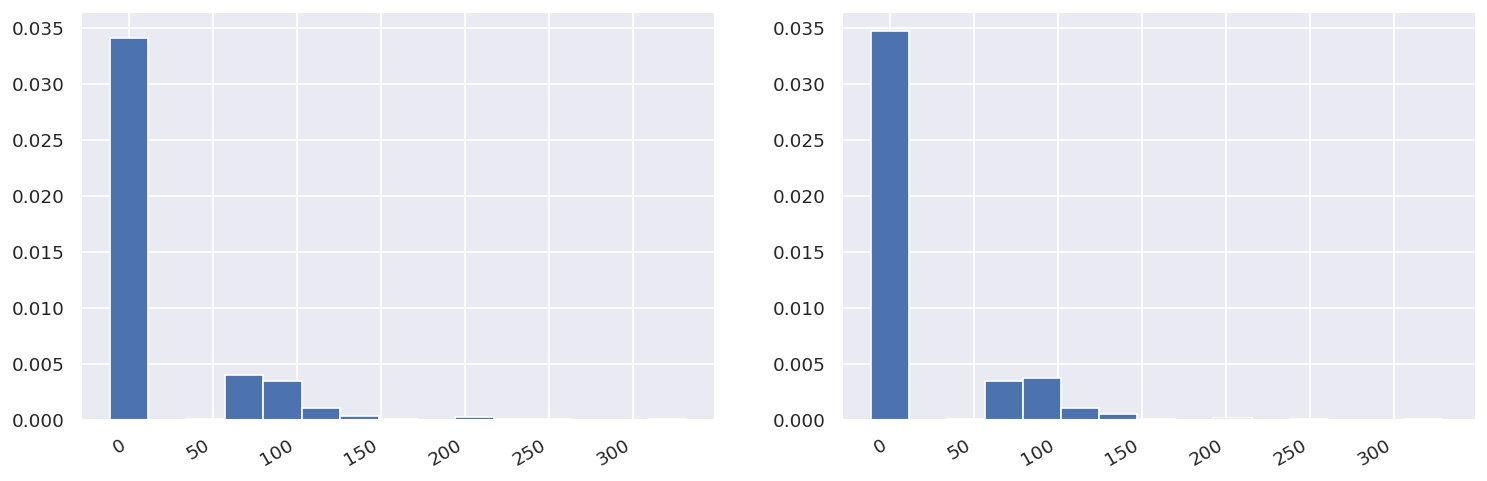

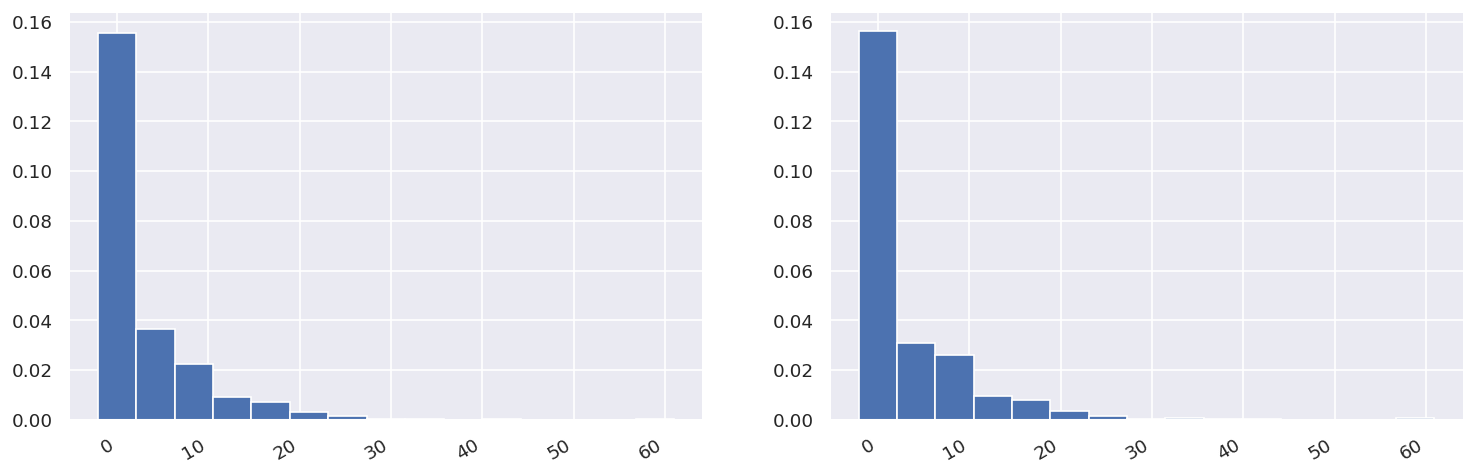

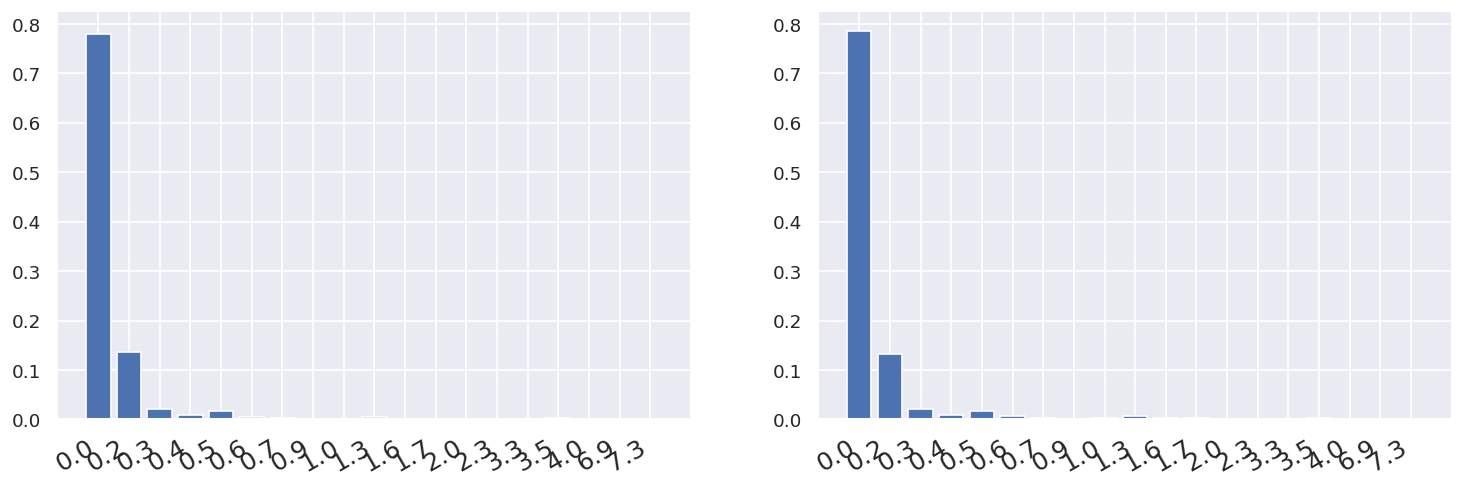

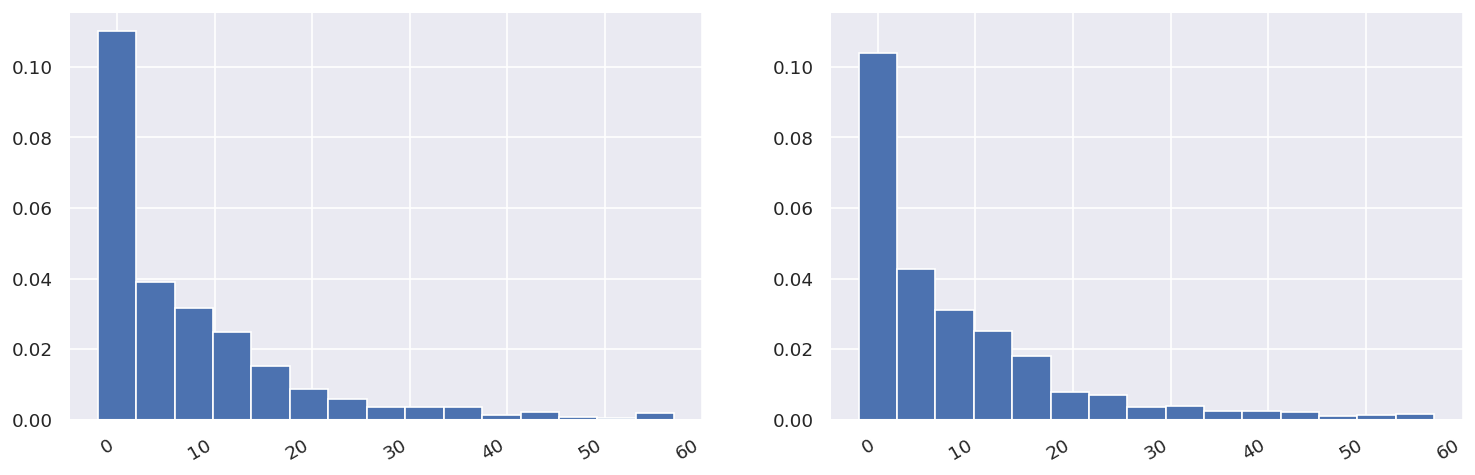

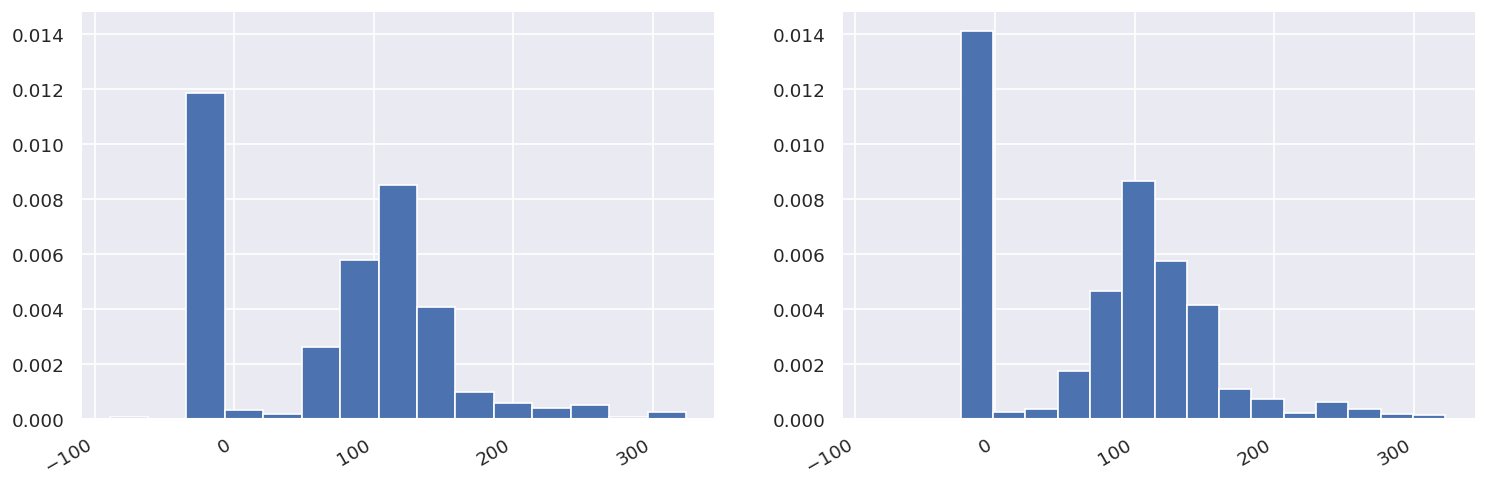

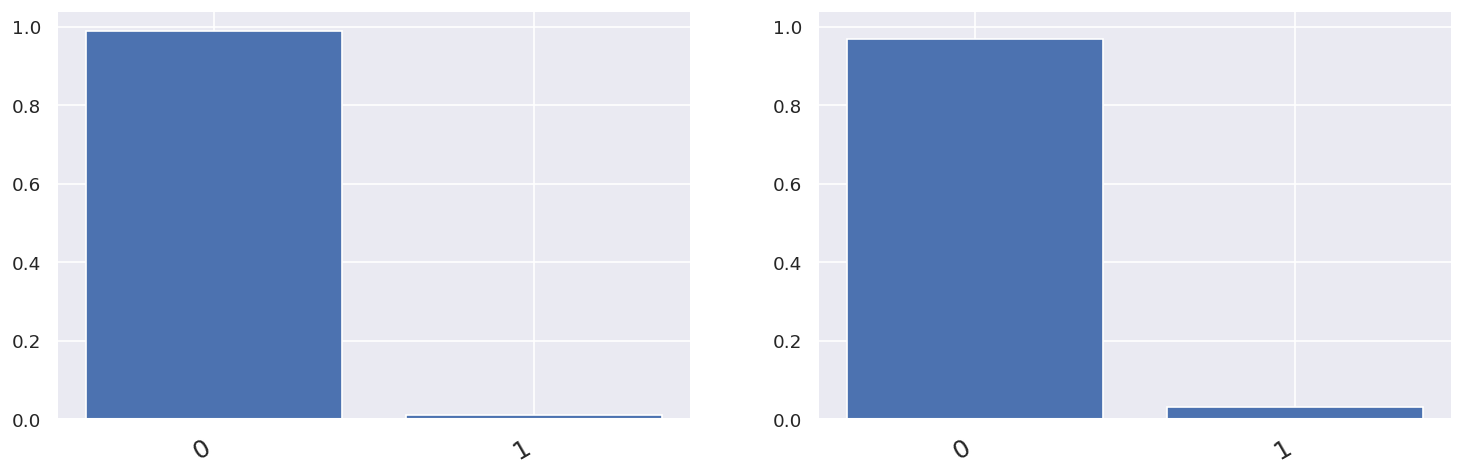

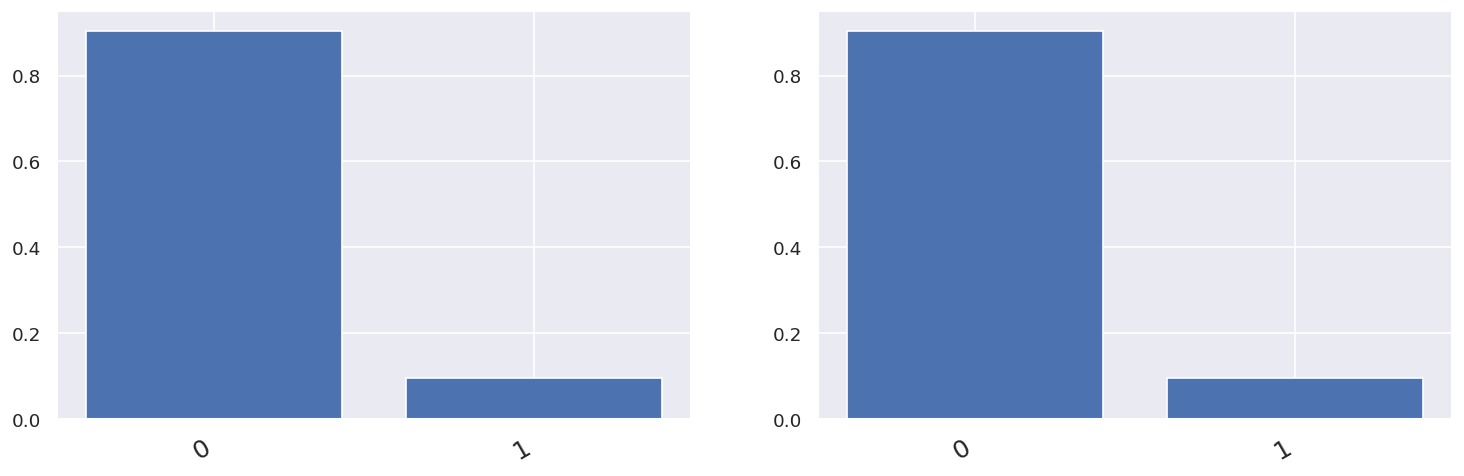

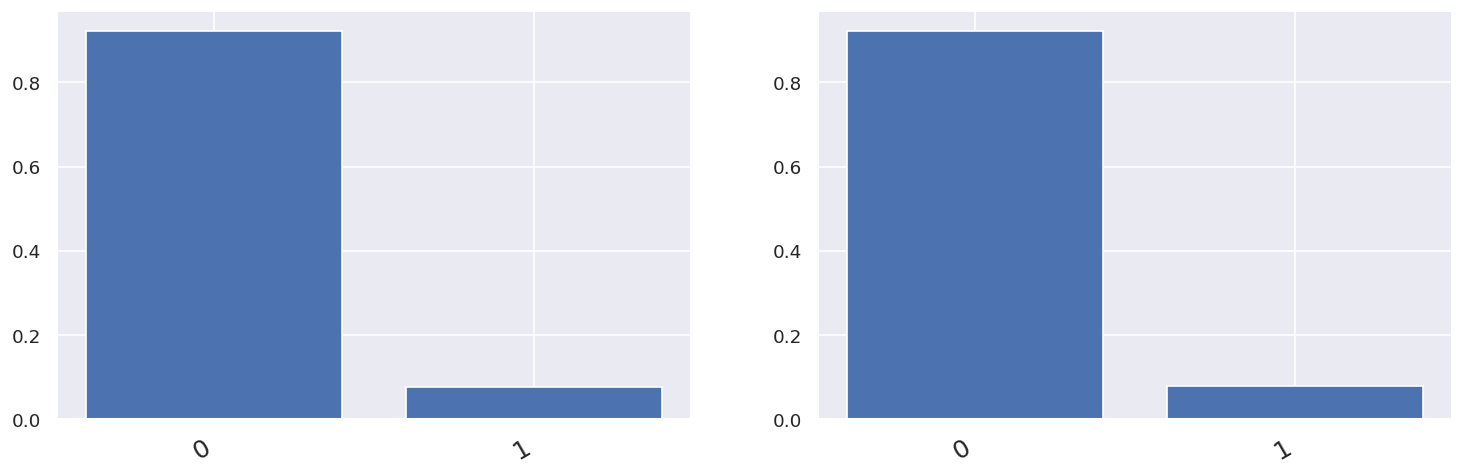

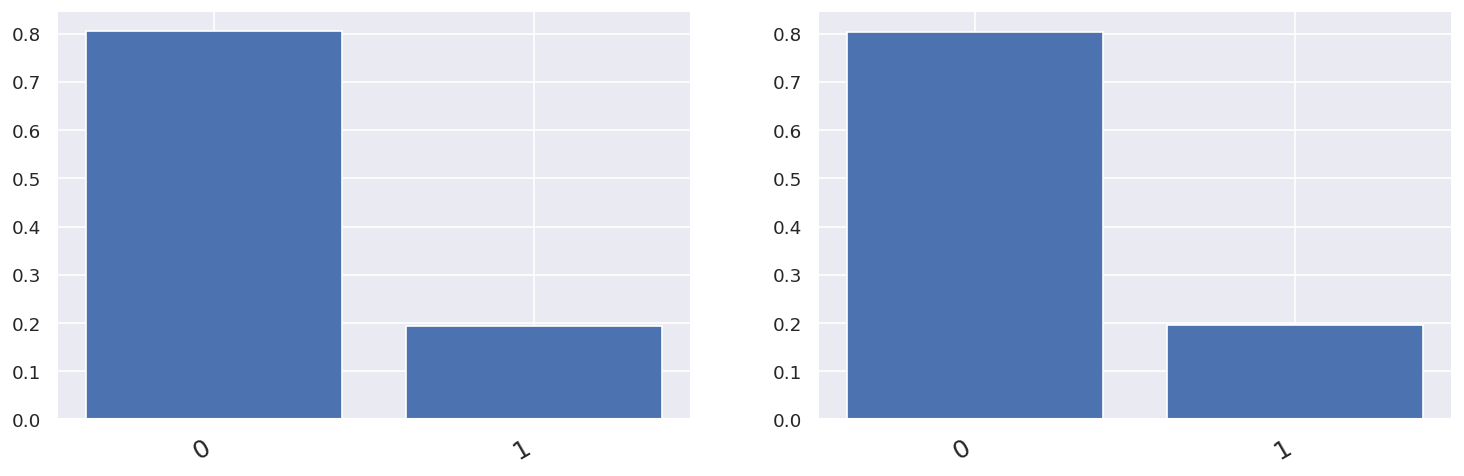

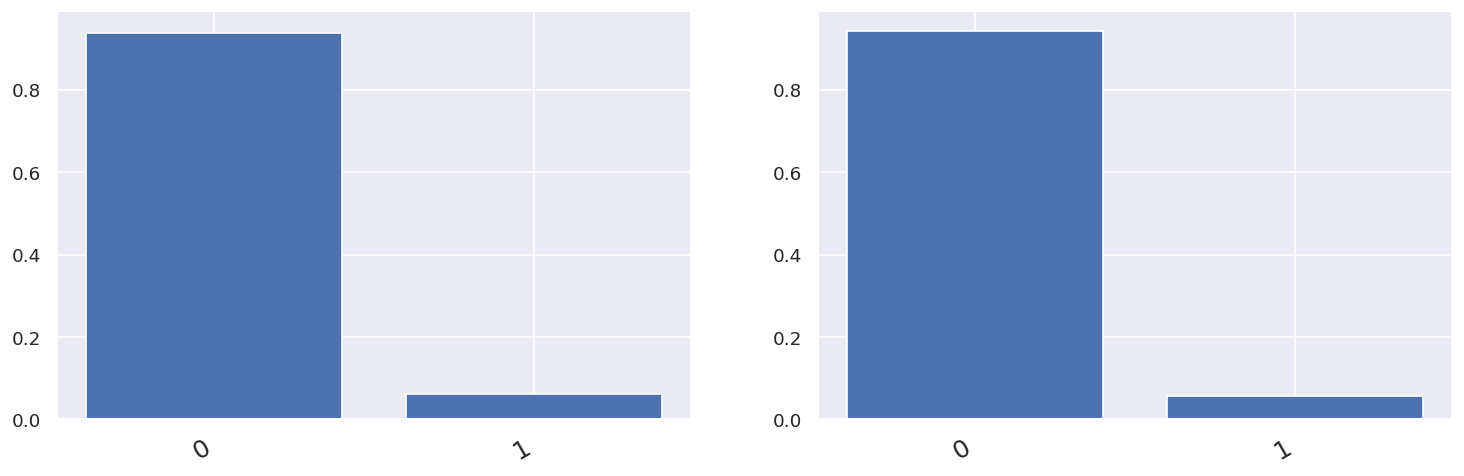

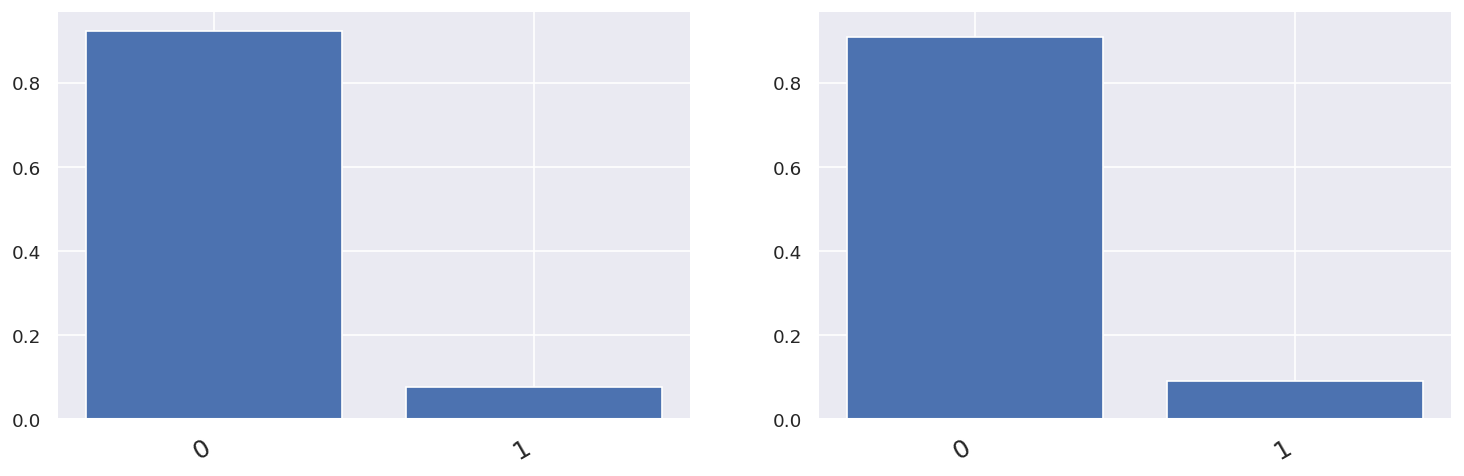

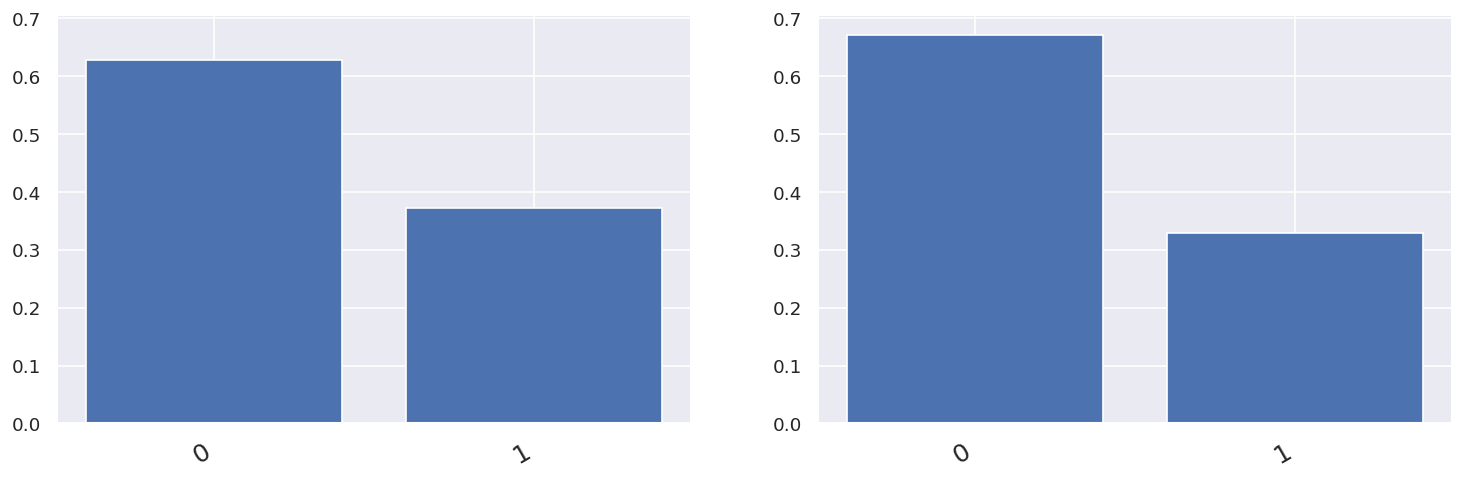

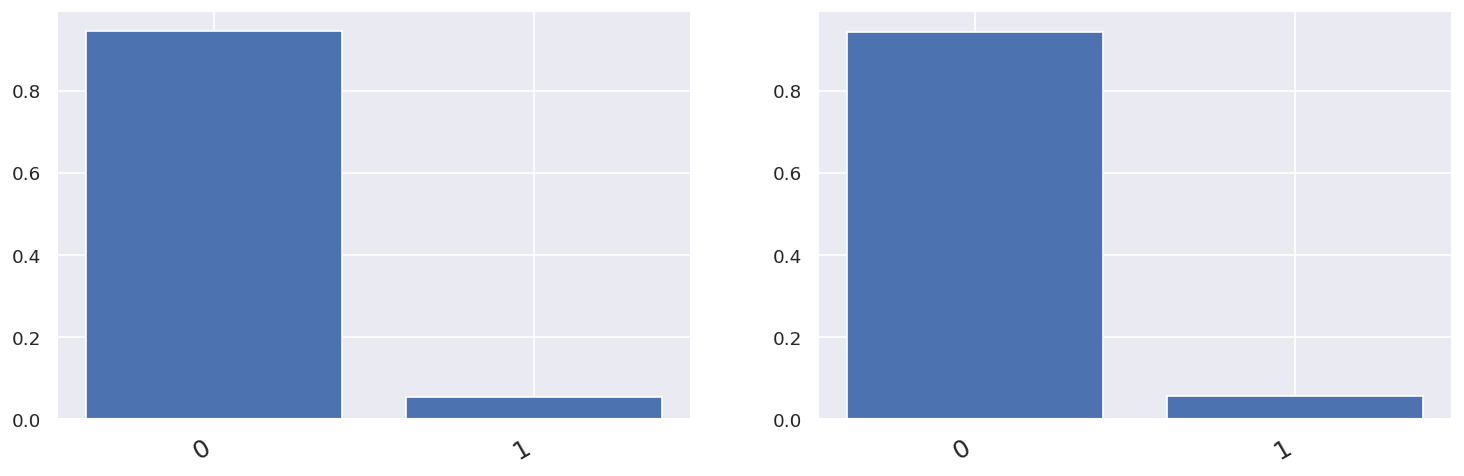

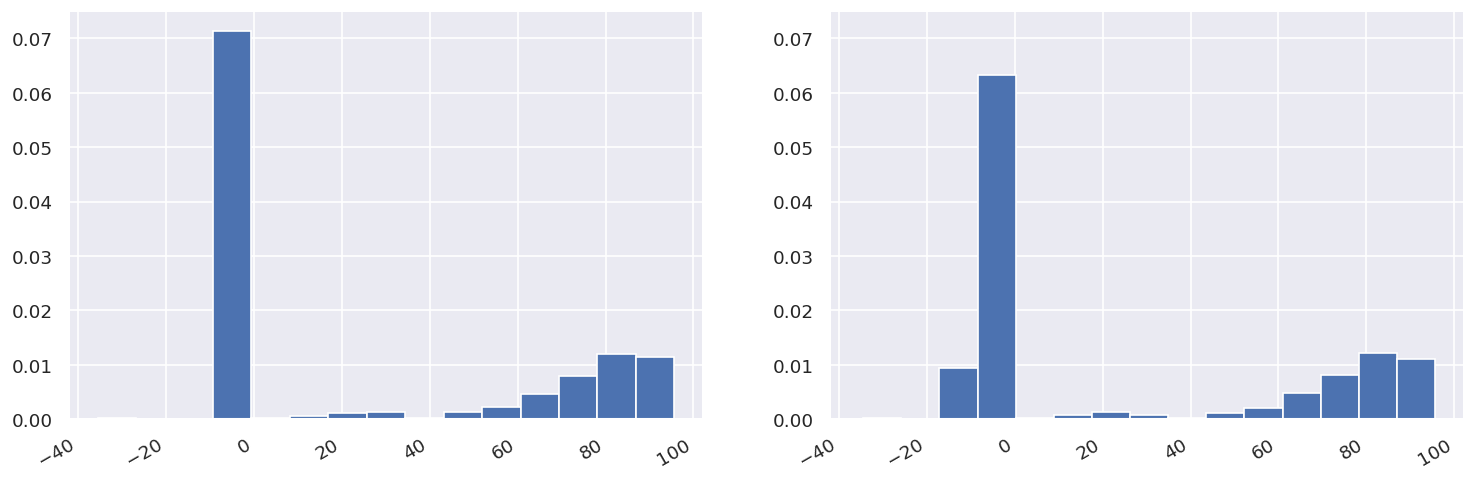

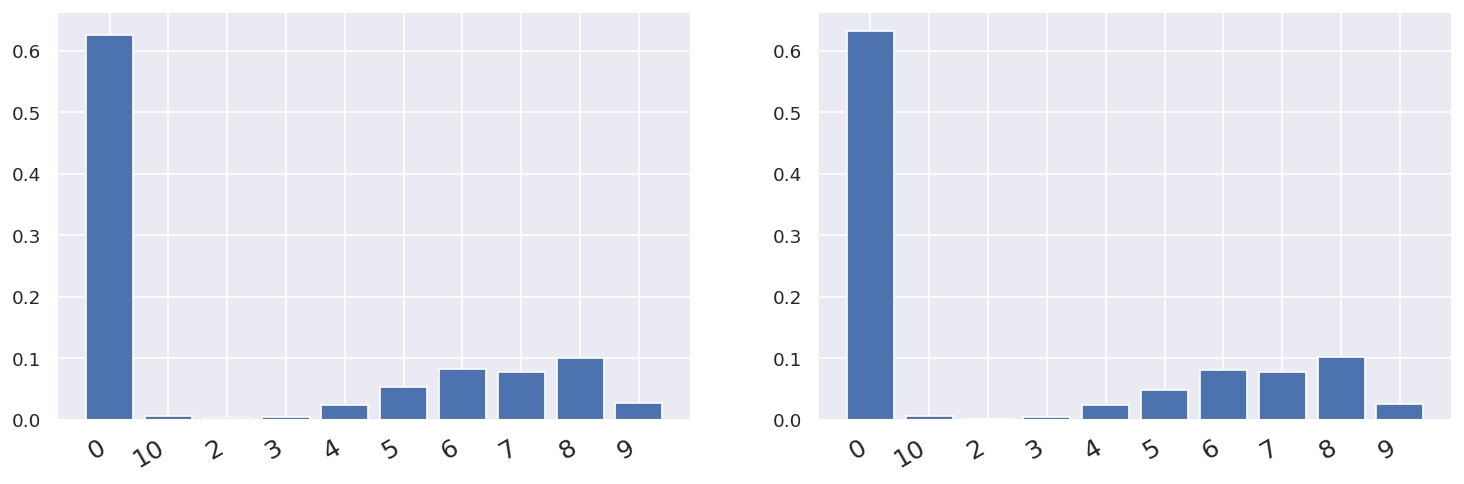

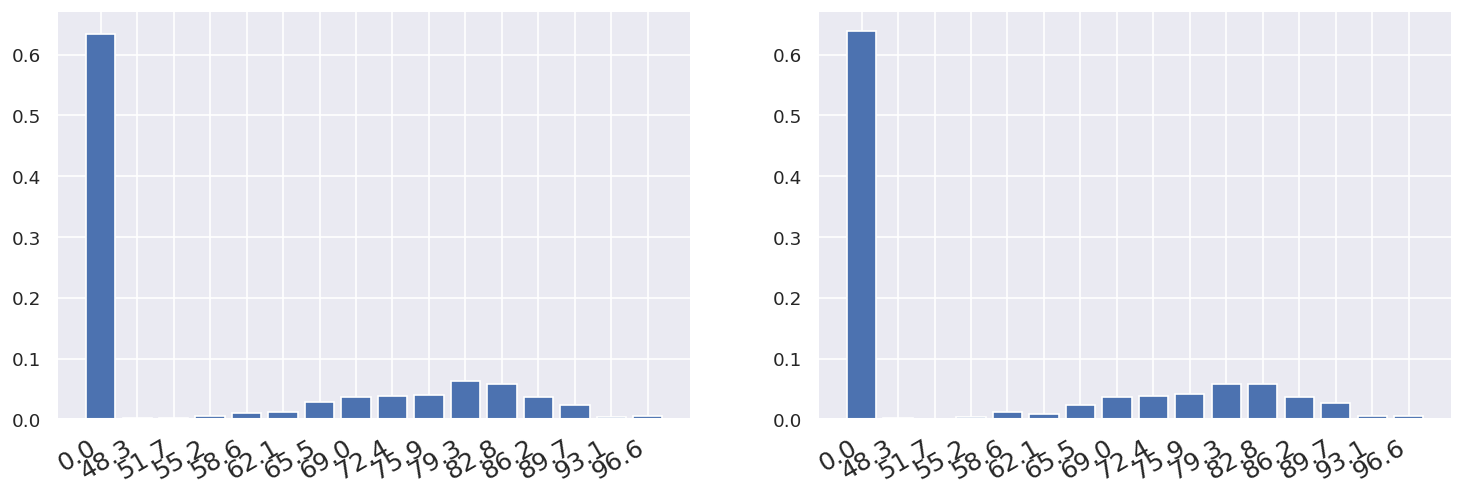

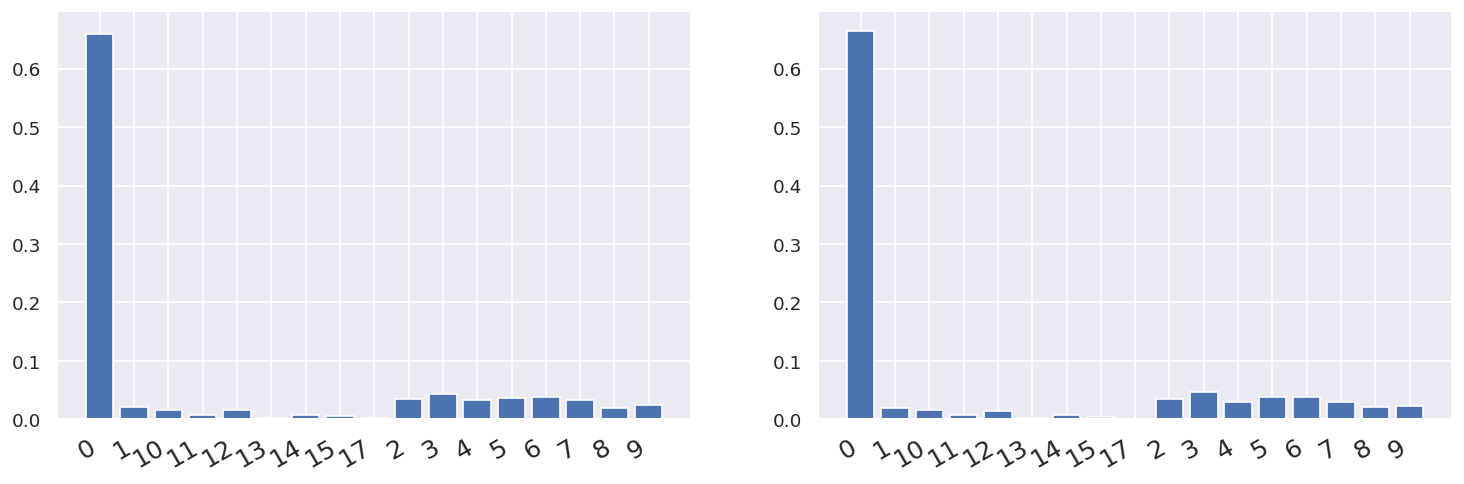

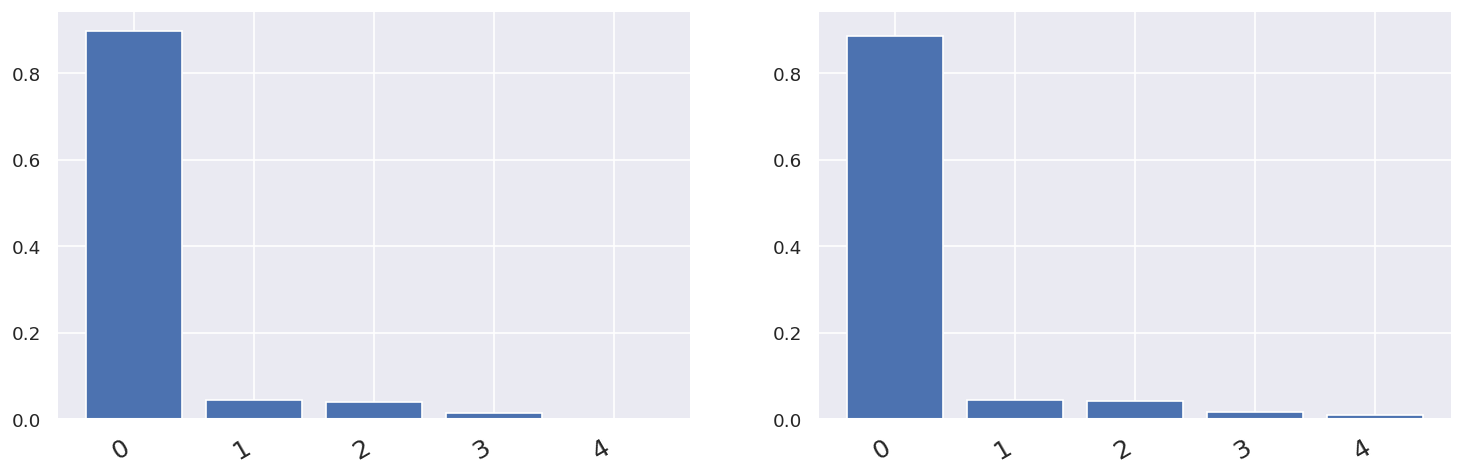

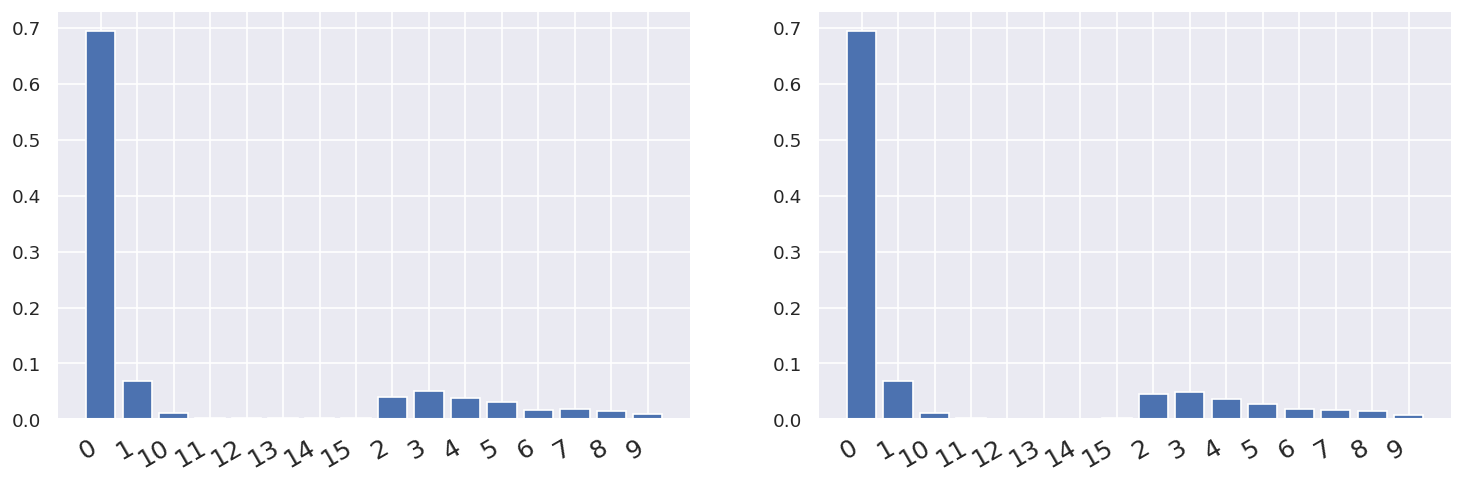

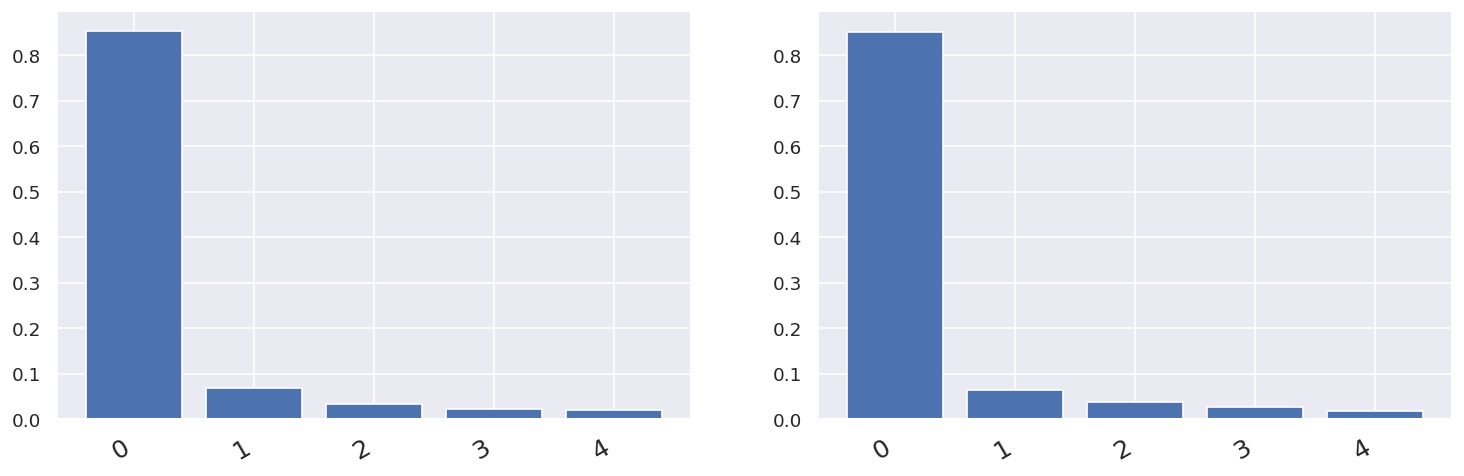

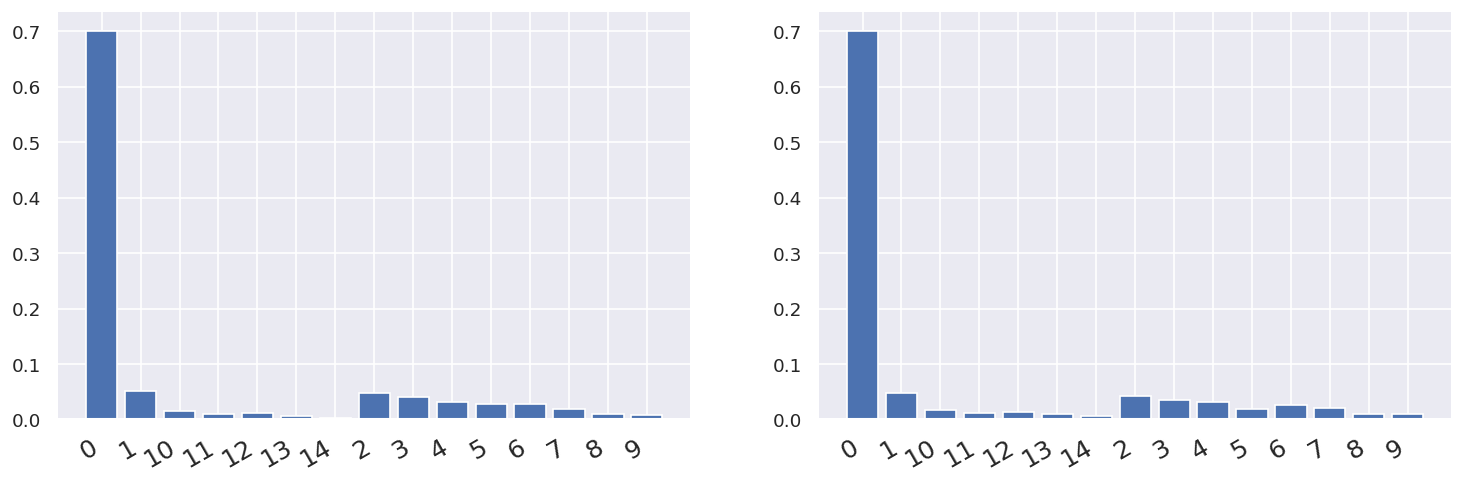

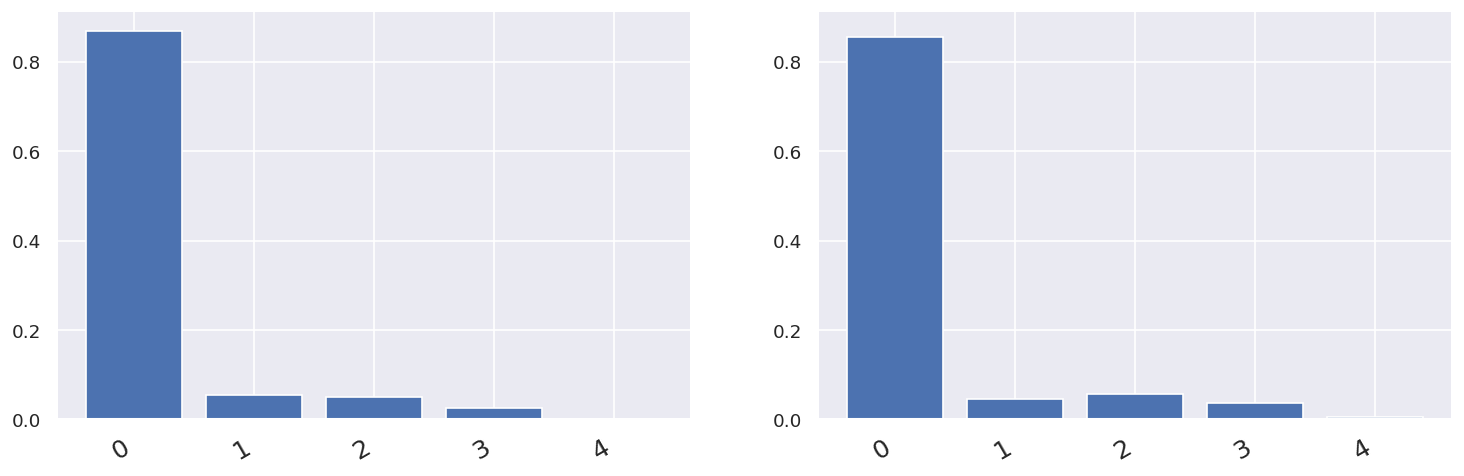

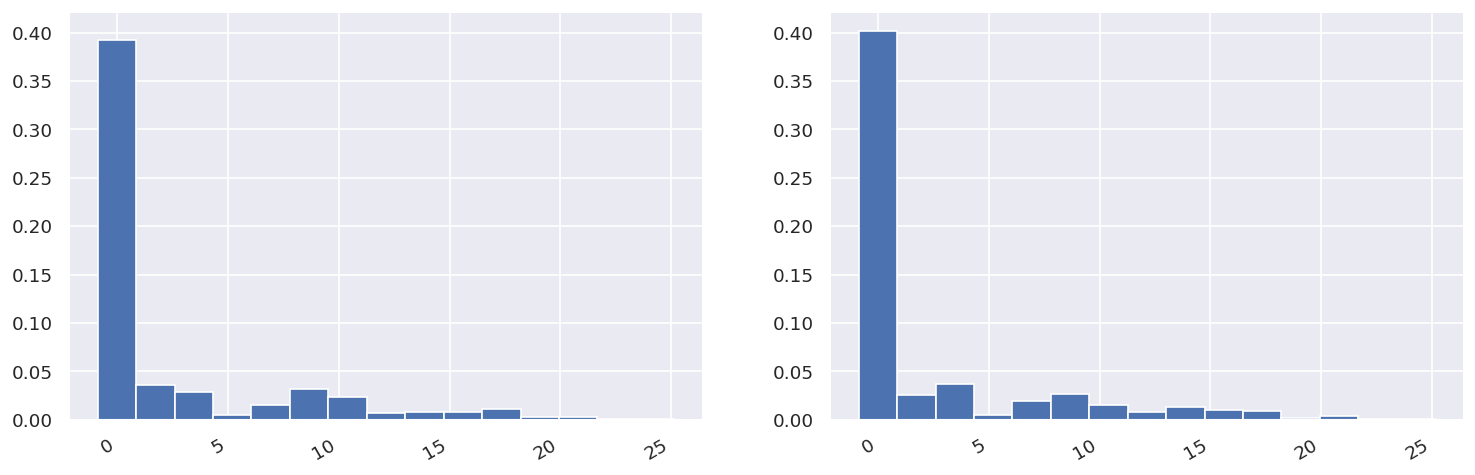

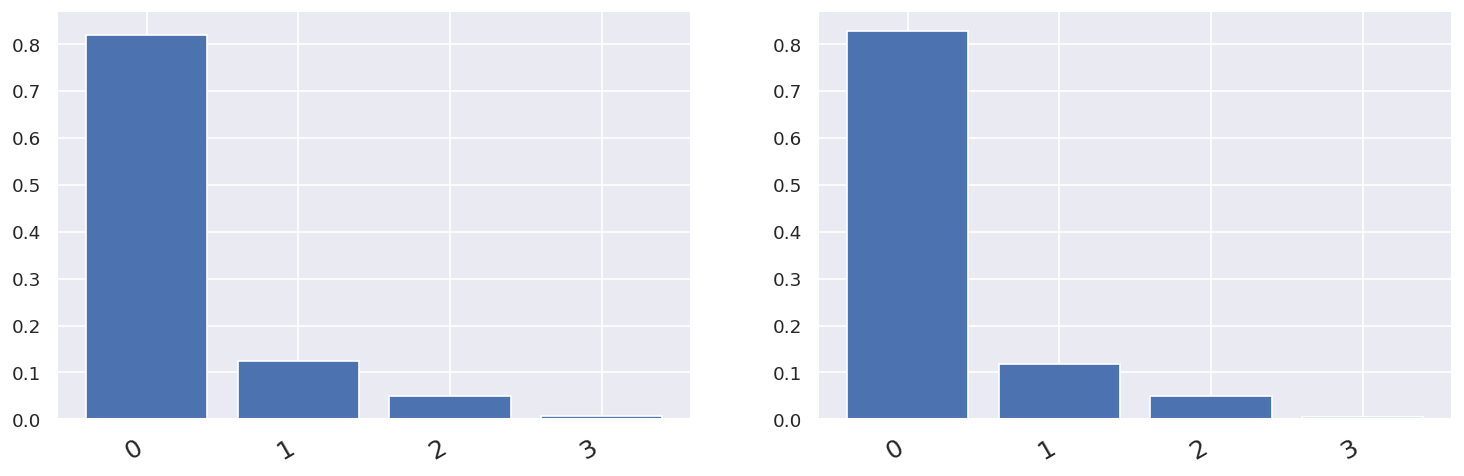

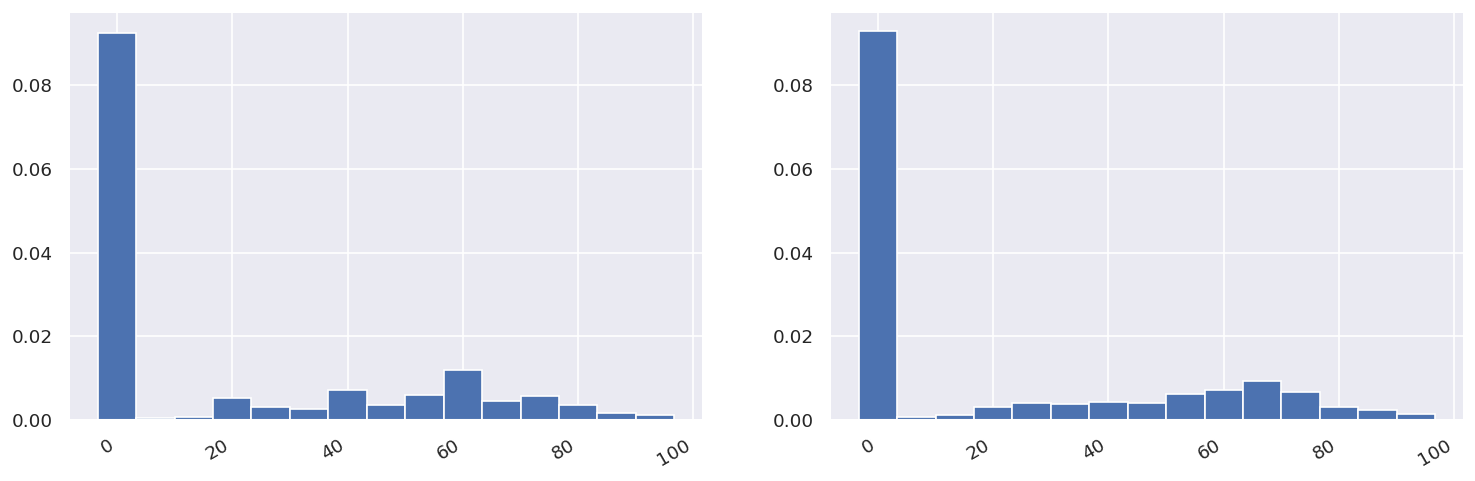

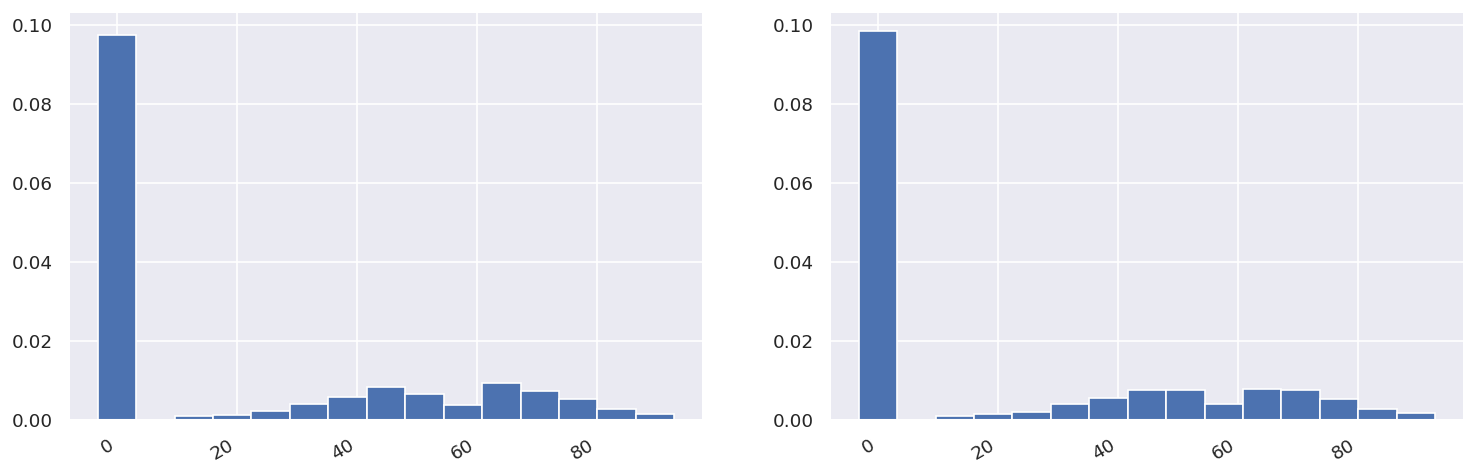

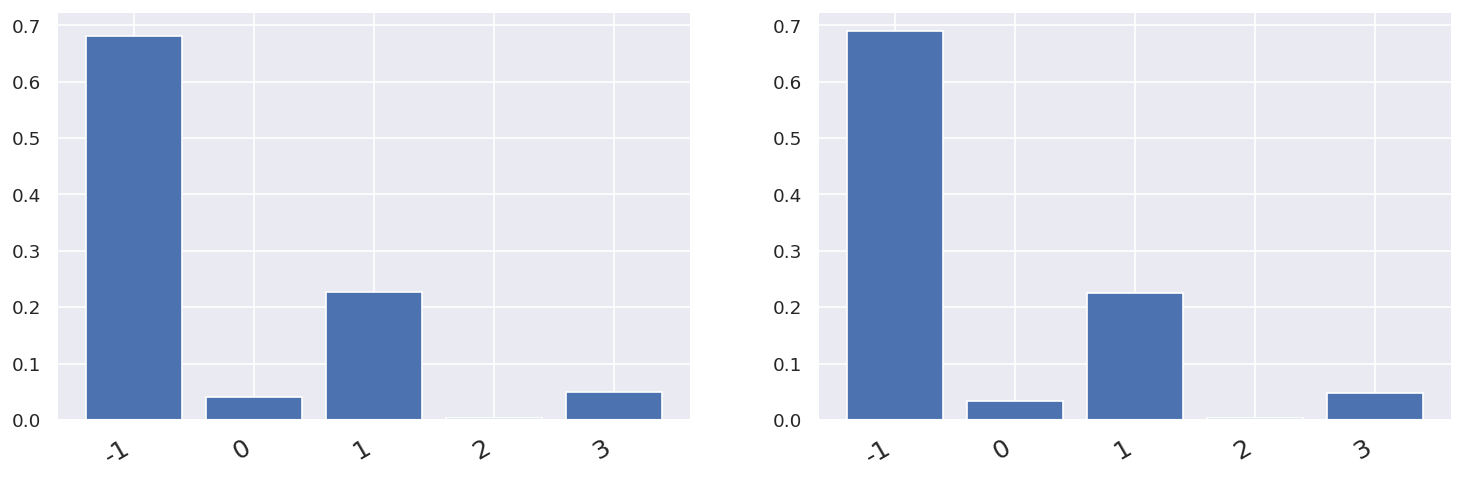

In [15]:
for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute)

In [16]:
#inspector.mutual_information_heatmap()

In [17]:
synthetic_df.head()

Sesso   ETA          DATA  ASCVD_Score  DATA_INT  num_visita  \
0      1  55.0  1.599269e+09     1.406930     382.0           0   
1      1  51.0  1.601155e+09    24.537133     378.0           0   
2      0  57.0  1.615683e+09     0.920490     222.0           0   
3      1  41.0  1.610522e+09    -0.749886     440.0           1   
4      1  50.0  1.596199e+09     0.667004     454.0           0   

   Charlson_Totale  Charlson_Diabete  Stifness    CAP  ...  Stress level  \
0                1                 0  5.613925  303.0  ...             2   
1                0                 0  5.835481  252.0  ...             0   
2                0                 0  1.724208    5.0  ...             0   
3                0                 0  1.188049   17.0  ...             0   
4                0                 0  2.399765    7.0  ...             0   

   DASS21 anxiety  Anxiety level  DASS21 depression  Depression level  \
0               2              0                  4                 0   
1               0              0                  2                 0   
2               0              0                  0                 0   
3               0              0                  0                 0   
4               2              0                  0                 0   

   Insomnia severity index  ISI level  SF36 general health  Resilience  \
0                     14.0          1                 42.0        67.0   
1                      1.0          0                 59.0         4.0   
2                      0.0          0                  5.0         3.0   
3                      4.0          0                 60.0        63.0   
4                      0.0          0                 57.0        54.0   

   Outcome  
0        1  
1       -1  
2       -1  
3        1  
4        0  

[5 rows x 79 columns]

In [18]:
'''plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True)
plt.show()'''

'plt.figure(figsize=(8, 6))\nsns.heatmap(df.corr(), annot=True)\nplt.show()'

In [19]:
dfs.head()

HDN_CODE  Sesso   ETA          DATA  ASCVD_Score  DATA_INT  num_visita  \
0         0      1  55.0  1.599269e+09     1.406930     382.0           0   
1         1      1  51.0  1.601155e+09    24.537133     378.0           0   
2         2      0  57.0  1.615683e+09     0.920490     222.0           0   
3         3      1  41.0  1.610522e+09    -0.749886     440.0           1   
4         4      1  50.0  1.596199e+09     0.667004     454.0           0   

   Charlson_Totale  Charlson_Diabete  Stifness  ...  Stress level  \
0                1                 0  5.613925  ...             2   
1                0                 0  5.835481  ...             0   
2                0                 0  1.724208  ...             0   
3                0                 0  1.188049  ...             0   
4                0                 0  2.399765  ...             0   

   DASS21 anxiety  Anxiety level  DASS21 depression  Depression level  \
0               2              0                  4                 0   
1               0              0                  2                 0   
2               0              0                  0                 0   
3               0              0                  0                 0   
4               2              0                  0                 0   

   Insomnia severity index  ISI level  SF36 general health  Resilience  \
0                     14.0          1                 42.0        67.0   
1                      1.0          0                 59.0         4.0   
2                      0.0          0                  5.0         3.0   
3                      4.0          0                 60.0        63.0   
4                      0.0          0                 57.0        54.0   

   Outcome  
0        1  
1       -1  
2       -1  
3        1  
4        0  

[5 rows x 80 columns]

In [20]:
df.head()

HDN_CODE  Sesso  ETA                DATA  ASCVD_Score  DATA_INT  \
0      2236      0   64 2021-02-26 00:00:00        27.30       422   
1      6426      0   48 2021-04-02 00:00:00         2.56       457   
2      8377      0   56 2020-08-31 00:00:00         7.80       243   
3     11463      0   71 2020-08-31 00:00:00        24.74       243   
4     11463      0   71 2021-03-31 10:54:33         0.00       456   

   num_visita  Charlson_Totale  Charlson_Diabete  Stifness  ...  Stress level  \
0           0                0                 0       6.7  ...             0   
1           0                2                 0       0.0  ...             0   
2           0                1                 0       0.0  ...             0   
3           0                3                 0       0.0  ...             0   
4           1                0                 0       0.0  ...             0   

   DASS21 anxiety  Anxiety level  DASS21 depression  Depression level  \
0               0              0                  0                 0   
1               4              1                  7                 2   
2               0              0                  0                 0   
3               0              0                  0                 0   
4               0              0                  0                 0   

   Insomnia severity index  ISI level  SF36 general health  Resilience  \
0                        8          1                   75          64   
1                        6          0                   10          54   
2                        0          0                    0           0   
3                        0          0                    0           0   
4                        0          0                   90          88   

   Outcome  
0        1  
1        0  
2       -1  
3       -1  
4        3  

[5 rows x 80 columns]

In [21]:
frames = [df, dfs]

result = pd.concat(frames)

In [22]:
X = result[(result['FrailtyPhenotypeBool'] != -1) & (result['Resilience'] != -1)]
X.drop(columns=['FrailtyPhenotypeBool', 'Resilience', 'Outcome', 'DATA'], inplace=True)

y = result[(result['FrailtyPhenotypeBool'] != -1) & (result['Resilience'] != -1)]['Outcome']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)#, shuffle=False)

In [23]:
model = XGBClassifier()
model.fit(x_train, y_train)

y_test_hat = model.predict(x_test) 

accuracy_score(y_test, y_test_hat)

/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:02:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9250720461095101

In [24]:
X.shape, result.shape

((5551, 76), (5551, 80))

In [25]:
dfs

HDN_CODE  Sesso   ETA          DATA  ASCVD_Score  DATA_INT  num_visita  \
0            0      1  55.0  1.599269e+09     1.406930     382.0           0   
1            1      1  51.0  1.601155e+09    24.537133     378.0           0   
2            2      0  57.0  1.615683e+09     0.920490     222.0           0   
3            3      1  41.0  1.610522e+09    -0.749886     440.0           1   
4            4      1  50.0  1.596199e+09     0.667004     454.0           0   
...        ...    ...   ...           ...          ...       ...         ...   
4995      4995      0  48.0  1.616955e+09     1.136205     244.0           0   
4996      4996      0  74.0  1.610726e+09    -0.561288     447.0           0   
4997      4997      0  54.0  1.600114e+09     0.111027     350.0           0   
4998      4998      0  66.0  1.608054e+09     9.757193     422.0           1   
4999      4999      0  70.0  1.607280e+09    -0.303177     268.0           0   

      Charlson_Totale  Charlson_Diabete   Stifness  ...  Stress level  \
0                   1                 0   5.613925  ...             2   
1                   0                 0   5.835481  ...             0   
2                   0                 0   1.724208  ...             0   
3                   0                 0   1.188049  ...             0   
4                   0                 0   2.399765  ...             0   
...               ...               ...        ...  ...           ...   
4995                0                 0   0.112755  ...             0   
4996                0                 0   1.000668  ...             0   
4997                0                 0   0.557105  ...             0   
4998                0                 0   3.339906  ...             0   
4999                0                 0  15.059442  ...             0   

      DASS21 anxiety  Anxiety level  DASS21 depression  Depression level  \
0                  2              0                  4                 0   
1                  0              0                  2                 0   
2                  0              0                  0                 0   
3                  0              0                  0                 0   
4                  2              0                  0                 0   
...              ...            ...                ...               ...   
4995               0              0                  0                 0   
4996               7              2                 10                 2   
4997               0              0                  0                 0   
4998               0              0                  2                 0   
4999               0              0                  0                 0   

      Insomnia severity index  ISI level  SF36 general health  Resilience  \
0                        14.0          1                 42.0        67.0   
1                         1.0          0                 59.0         4.0   
2                         0.0          0                  5.0         3.0   
3                         4.0          0                 60.0        63.0   
4                         0.0          0                 57.0        54.0   
...                       ...        ...                  ...         ...   
4995                      1.0          0                  3.0         2.0   
4996                     17.0          2                 69.0        38.0   
4997                      1.0          0                  0.0         2.0   
4998                      1.0          0                 80.0        63.0   
4999                      0.0          0                  4.0         3.0   

      Outcome  
0           1  
1          -1  
2          -1  
3           1  
4           0  
...       ...  
4995       -1  
4996        1  
4997       -1  
4998        1  
4999       -1  

[5000 rows x 80 columns]